In [1]:
!pip install pyvis python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.4 MB/s eta 0:00:00 0:00:01


In [2]:


import numpy as np
import pandas as pd 
import networkx as nx
import ast
import json
import matplotlib.pyplot as plt

import random
import seaborn as sns
import re
from collections import Counter
import ast

# this pakcage help us to understand the conguested and high nodes graph

from pyvis.network import Network
# this package help us to parallely run the loop over large dataset

from multiprocessing import Pool
from itertools import combinations

# community detection 
from community import community_louvain
from networkx.algorithms.community import girvan_newman
from itertools import islice



In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sna-project-files/task5_analysis.csv
/kaggle/input/sna-project-files/task2_df.parquet
/kaggle/input/sna-project-files/task5_correlations.csv
/kaggle/input/sna-project-files/task2_graph.gml
/kaggle/input/tripadvisor-european-restaurants/tripadvisor_european_restaurants.csv


In [4]:
# reading (csv) dataset via pandas

resturant_file="/kaggle/input/tripadvisor-european-restaurants/tripadvisor_european_restaurants.csv"
df=pd.read_csv(resturant_file, low_memory=False)
df.head()



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,...,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
0,g10001637-d10002227,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,...,2.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,NaN,NaN
1,g10001637-d14975787,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,...,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,g10002858-d4586832,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,...,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,g10002986-d3510044,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,...,1.0,0.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN
4,g10022428-d9767191,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Occitanie,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,...,4.0,7.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN


### displaying the Null in each columns

In [9]:

df_isnull=df.isna().mean()*100

print("-" * 50)
# print(df_isnull)


null_arr = [df.columns[i] for i in range(len(df_isnull)) if df_isnull.iloc[i] >= 40]

# print("---"*10, null_arr)

# columns_to_drop=["awards","open_days_per_week","open_hours_per_week","working_shifts_per_week","atmosphere","default_language","atmosphere"]


# # dropped such columns which is not important
# df=df.drop(columns=columns_to_drop)

# Display the new shape and columns with >40% null values
print(df.count, "\n\nabove forty\n")

# above_forty=df.isna().mean()*100>=40
# print(df.shape,"\n\nabove forty\n",null_arr)

--------------------------------------------------
<bound method DataFrame.count of              restaurant_link               restaurant_name  \
0        g10001637-d10002227                        Le 147   
1        g10001637-d14975787              Le Saint Jouvent   
2         g10002858-d4586832               Au Bout du Pont   
3         g10002986-d3510044           Le Relais de Naiade   
4         g10022428-d9767191          Relais Du MontSeigne   
...                      ...                           ...   
1083392   g9710275-d10770782        Complex Popas Pacurari   
1083393   g9716321-d15026574  Casa Pastravarului DORIPESCO   
1083394   g9722813-d15891057                  Hanul Tentea   
1083395   g9726871-d21391722                 Casa Paduraru   
1083396   g9867250-d14979687       Pastravaria Alina Sarbi   

                                         original_location  country  \
0        ["Europe", "France", "Nouvelle-Aquitaine", "Ha...   France   
1        ["Europe", "France",

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


### Handling missing dataset

In [11]:

# Handle location-related columns
df['province'] = df['province'].fillna("Unknown")
df['city'] = df['city'].fillna("Unknown")
df['address'] = df['address'].fillna("Unknown")

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude'])

print(df['province'].isnull().any())
print(df['city'].isnull().any())
print(df['address'].isnull().any())

False
False
False


In [10]:
#converting objects arrays to list 
def parse_list(x):
    if isinstance(x, str) and x.startswith('['):
        return ast.literal_eval(x)
    return x if isinstance(x, list) else []
    

### out of 42, 13 columns are dropped, as they were not required.
columns names are below

1. restaurant_link
2. value
3. region
4. price_level
5. original_open_hours
6. terrible
7. keywords
8. awards
9. open_days_per_week
10. open_hours_per_week
11. working_shifts_per_week
12. atmosphere
13. default_language



In [17]:
# df['gluten_free'].dtype
# print(df['special_diets'].isnull().any())

# columns_to_drop=["restaurant_link","value","region","price_level","original_open_hours","terrible","keywords"]

# # # dropped such columns which is not important
# df=df.drop(columns=columns_to_drop)

# print(df.head())
for i in df.columns:
    print(df[i].head(20))

0                          Le 147
1                Le Saint Jouvent
2                 Au Bout du Pont
3             Le Relais de Naiade
4            Relais Du MontSeigne
5       L'Auberge Du Vieux Crozet
6          Cafe Restaurant NouLou
7                       L'entre 2
8                   Noste Courtiu
9                   Chez Claudine
10            Le Petit Campagnard
11                      Chez Jiji
12                         Angkor
13                   L'Original'S
14             L'Impro Restaurant
15           Pietra Foci Rocbaron
16                  Tip top pizza
17                     L'Antidote
18                    La terrasse
19    Cafe Restaurant le Papareil
Name: restaurant_name, dtype: object
0     ["Europe", "France", "Nouvelle-Aquitaine", "Ha...
1     ["Europe", "France", "Nouvelle-Aquitaine", "Ha...
2     ["Europe", "France", "Centre-Val de Loire", "B...
3     ["Europe", "France", "Nouvelle-Aquitaine", "Co...
4     ["Europe", "France", "Occitanie", "Aveyron", "...
5  

In [18]:


# Handle attributes/features

df['popularity_detailed']=df['popularity_detailed'].fillna("Unknown")
df['popularity_generic']=df['popularity_generic'].fillna("Unknown")
df['top_tags']=df['top_tags'].fillna("[]")

df['price_range']=df['price_range'].fillna("€0")

df['cuisines']=df['cuisines'].fillna('[]')
df['special_diets']=df['special_diets'].fillna('[]')
df['features']=df['features'].fillna('[]')
df['meals'] = df['meals'].fillna('[]')

 # df['vegetarian_friendly'].fillna('No')
 # df['vegan_options'].fillna('No')
# df['gluten_free'].fillna('No')
df['city']= df['city'].fillna('Unknown')


print(df['popularity_detailed'].isnull().any())
print(df['popularity_generic'].isnull().any())
print(df['top_tags'].isnull().any())
# print(df['price_level'].isnull().any())
print(df['price_range'].isnull().any())


# print(df['features'].dtype)

# Convert list-like columns to actual lists
list_columns = ['meals', 'cuisines', 'special_diets', 'features','top_tags','']
for col in list_columns:
    df[col].apply(parse_list)
    

False
False
False
False


In [25]:
print(df['special_diets'].isna().mean()*100)

0.0


In [29]:

# Handle numeric ratings/reviews
numeric_columns = [
    'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language',
    'excellent', 'very_good', 'average', 'poor',
    'food', 'service',
]
for col in numeric_columns:
    df[col]=df[col].fillna(0.0)

print(df['very_good'].head(100))

0      0.0
1      2.0
2      1.0
3      0.0
4      7.0
      ... 
96     0.0
97     1.0
98     3.0
99     1.0
100    4.0
Name: very_good, Length: 100, dtype: float64


In [30]:
# Function to parse JSON-like strings
def parse_open_hours(value):
    try:
        return json.loads(value) if isinstance(value, str) else {}
    except json.JSONDecodeError:
        return {}


In [37]:
# Boolean flags
# print(df['gluten_free'].isna().mean()*100)
boolean_columns = ['vegetarian_friendly', 'vegan_options', 'gluten_free']
for col in boolean_columns:
    df[col] = df[col].fillna('N')

print(df['vegan_options'].head(150))

0      N
1      N
2      N
3      N
4      N
      ..
146    N
147    Y
148    N
149    N
150    N
Name: vegan_options, Length: 150, dtype: object


In [ ]:
# # Convert valid strings to lists, handle arrays, and fill missing values with empty lists
# df['keywords'] = df['keywords'].apply(
#     lambda x: 
#         [] if isinstance(x, float) and np.isnan(x) else  # Handle NaN/missing values
#         (x.split(", ") if isinstance(x, str) else  # Handle strings
#          list(x) if isinstance(x, (list, np.ndarray)) else  # Handle lists or arrays
#          [])
# )

In [38]:

# Fill missing value with "Unknown"
df['restaurant_name'] = df['restaurant_name'].fillna("Unknown")

# Fill missing values with "Unclaimed"
df['claimed'] = df['claimed'].fillna("Unclaimed")

In [39]:
df

,restaurant_name,original_location,country,province,city,address,latitude,longitude,claimed,popularity_detailed,...,gluten_free,avg_rating,total_reviews_count,reviews_count_in_default_language,excellent,very_good,average,poor,food,service
0,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,Claimed,#1 of 2 Restaurants in Saint-Jouvent,...,N,4.0,36.0,2.0,2.0,0.0,0.0,0.0,4.0,4.5
1,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,Unclaimed,#2 of 2 Restaurants in Saint-Jouvent,...,N,4.0,5.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0
2,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,Claimed,#1 of 1 Restaurant in Rivarennes,...,N,5.0,13.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0
3,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,Claimed,#1 of 1 Restaurant in Lacelle,...,N,4.0,34.0,1.0,1.0,0.0,0.0,0.0,4.5,4.5
4,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,Unclaimed,#1 of 1 Restaurant in Saint-Laurent-de-Levezou,...,N,4.5,11.0,11.0,4.0,7.0,0.0,0.0,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083392,Complex Popas Pacurari,"[""Europe"", ""Romania"", ""Northeast Romania"", ""Ia...",Romania,Iasi County,Unknown,"Soseaua Pacurari, Valea Lupului 707410 Romania",47.172950,27.519110,Unclaimed,#1 of 1 Restaurant in Valea Lupului,...,N,2.5,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1083393,Casa Pastravarului DORIPESCO,"[""Europe"", ""Romania"", ""Transylvania"", ""Central...",Romania,Brasov County,Apata,"DN 13 Judetul Kilometrul 33 Maierus, Apata 507...",45.904423,25.470509,Claimed,#1 of 1 Restaurant in Apata,...,N,2.0,6.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0
1083394,Hanul Tentea,"[""Europe"", ""Romania"", ""Transylvania"", ""Northwe...",Romania,Maramures County,Sacel,"DN17C, Sacel Romania",47.631920,24.450910,Unclaimed,#1 of 1 Restaurant in Sacel,...,N,3.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1083395,Casa Paduraru,"[""Europe"", ""Romania"", ""Southern Romania"", ""Arg...",Romania,Arges County,Unknown,"Sat. Argeselu Numarul 432, Maracineni 117450 R...",44.918950,24.867634,Claimed,Unknown,...,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Verify the preprocessing
print("Are there any missing values after preprocessing?", df.isnull().any().any())
# print(df['meals'][:10])

# # Check for columns with missing values
missing_columns = []

for col in df.columns:
    if df[col].isnull().any():  # Check if any missing values exist in the column
        missing_count = df[col].isnull().sum()  # Count the number of missing values
        missing_percentage = (missing_count / len(df)) * 100  # Calculate percentage
        missing_columns.append((col, missing_count, missing_percentage))

# Print the columns with missing values
if missing_columns:
    print("Columns with missing values:")
    for col, count, percentage in missing_columns:
        print(f"Column: {col}, Missing Values: {count} ({percentage:.2f}%)")
else:
    print("No missing values found in any column.")

Are there any missing values after preprocessing? False
No missing values found in any column.


In [42]:
# Save the cleaned dataset to a CSV file
output_file_path = "/kaggle/working/cleaned_restaurants_data.csv"
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Save the cleaned dataset to a CSV file
df.to_csv(output_file_path, index=False)


print(f"Cleaned dataset saved to: {output_file_path}")

Cleaned dataset saved to: /kaggle/working/cleaned_restaurants_data.csv


### Working with cleaned dataset with 29 rows 

In [49]:
# reading a clean (csv) dataset via pandas


# Load dataset
# df = pd.read_csv('/kaggle/input/your_dataset.csv')  # Update path
print(f"Original dataset size: {len(df)}")

# # Reduce to 
target_size = 5000 
reduced_df = df.sample(n=target_size, random_state=42)
print(f"Reduced dataset size: {len(reduced_df)}")

# Save reduced dataset
reduced_df.to_parquet('/kaggle/working/reduced_dataset.parquet')
print("Reduced dataset saved to /kaggle/working/reduced_dataset.parquet")

df = pd.read_parquet('/kaggle/working/reduced_dataset.parquet')
print(f"Reduced dataset size: {len(df)}")
# resturant_file="/kaggle/working/cleaned_restaurants_data.csv"
# df=pd.read_csv(resturant_file, low_memory=False)
df.head()

Original dataset size: 10000
Reduced dataset size: 5000
Reduced dataset saved to /kaggle/working/reduced_dataset.parquet
Reduced dataset size: 5000


,restaurant_name,original_location,country,province,city,address,latitude,longitude,claimed,popularity_detailed,...,gluten_free,avg_rating,total_reviews_count,reviews_count_in_default_language,excellent,very_good,average,poor,food,service
469569,Dorotea Pool Bar,"[""Europe"", ""Spain"", ""Canary Islands"", ""Gran Ca...",Spain,Gran Canaria,San Bartolome de Tirajana,"Avenida de Tirma 5, 35100, San Bartolome de Ti...",27.758532,-15.570525,Claimed,#1 of 84 Restaurants in San Bartolome de Tirajana,...,N,5.0,150.0,42.0,38.0,3.0,1.0,0.0,5.0,5.0
704099,La Porta di San Gennaro,"[""Europe"", ""Italy"", ""Campania"", ""Province of N...",Italy,Province of Naples,Unknown,"Via Porta San Gennaro 40/41 Piazza Cavour, 801...",40.854980,14.256015,Claimed,#1263 of 2653 Restaurants in Naples,...,N,4.0,30.0,30.0,15.0,7.0,2.0,2.0,4.5,4.5
995306,Restaurante-Bar Moinho da Légua,"[""Europe"", ""Portugal"", ""Algarve"", ""Faro Distri...",Portugal,Faro District,Aljezur,"N120, Aljezur 8670-136 Portugal",37.261864,-8.811540,Unclaimed,#49 of 54 Restaurants in Aljezur,...,N,4.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
383562,El Atrio Del Mercado,"[""Europe"", ""Spain"", ""Castile and Leon"", ""Provi...",Spain,Province of Salamanca,Unknown,"Calle de Garcia de Quinones 14, 37005 Salamanc...",40.971153,-5.661311,Unclaimed,#200 of 487 Restaurants in Salamanca,...,N,4.5,12.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0
290826,Zur Post,"[""Europe"", ""Germany"", ""North Rhine-Westphalia""...",Germany,Unknown,Wettringen,"Kirchstr. 4, 48493 Wettringen, North Rhine-Wes...",52.209340,7.319510,Unclaimed,#3 of 4 Restaurants in Wettringen,...,N,5.0,5.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0


### 1. Graph Construction

* Create an undirected graph where nodes are restaurants.
* Connect two nodes if they share at least one attribute
  - cuisine
  - special_diets
  - features
  - or located in the same city.
* Store edge weights based on the number of shared features.

# Creating a graph based on restaurant name

In [50]:

# G= graph
G=nx.Graph()
# G.add_nodes_from(df['restaurant_name'])

# Add nodes with attributes
for index, row in df.iterrows():
    G.add_node(row['restaurant_name'], 
               city=row['city'], 
               cuisines=row['cuisines'], 
               special_diets=row['special_diets'], 
               features=row['features'])


# print("Nodes in G: ", (G.nodes(data=True)[:10]))
print(f"Number of nodes: {G.number_of_nodes()}")

for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"Node: {node}, Attributes: {attrs}")

Number of nodes: 4840
Node: Dorotea Pool Bar, Attributes: {'city': 'San Bartolome de Tirajana', 'cuisines': 'Bar, European, Grill', 'special_diets': 'Vegetarian Friendly', 'features': 'Takeout, Reservations, Outdoor Seating, Seating, Wheelchair Accessible, Serves Alcohol, Table Service'}
Node: La Porta di San Gennaro, Attributes: {'city': 'Unknown', 'cuisines': 'Italian, Mediterranean, Neapolitan, Campania, Southern-Italian, Seafood', 'special_diets': '[]', 'features': '[]'}
Node: Restaurante-Bar Moinho da Légua, Attributes: {'city': 'Aljezur', 'cuisines': 'Italian', 'special_diets': '[]', 'features': '[]'}
Node: El Atrio Del Mercado, Attributes: {'city': 'Unknown', 'cuisines': 'Mediterranean, Spanish, Cafe', 'special_diets': '[]', 'features': 'Seating, Table Service'}
Node: Zur Post, Attributes: {'city': 'Wettringen', 'cuisines': '[]', 'special_diets': '[]', 'features': '[]'}


### connecting edges now based on shared features or with city

In [51]:
for city, group in df.groupby('city'):
    group = group.reset_index()
    # print(f"Processing city: {city}, {len(group)} restaurants")
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            row1 = group.iloc[i]
            row2 = group.iloc[j]
            shared = 0
            
            # Checking  the shared attributes
            if set(row1['cuisines']) & set(row2['cuisines']):
                shared += 1
            if set(row1['special_diets']) & set(row2['special_diets']):
                shared += 1
            if set(row1['features']) & set(row2['features']):
                shared += 1
            if row1['city'] == row2['city']:
                shared += 1
            if shared > 0:
                G.add_edge(row1['restaurant_name'], row2['restaurant_name'], weight=shared)


In [52]:
# Verify
print(f"Edges added: {G.number_of_edges()}")
print(f"Sample edges: {list(G.edges(data=True))[:5]}")

# # Verify
# print(f"Edges added: {G.number_of_edges()}")
# print(f"Sample edges with weights: {list(G.edges(data=True))[:5]}")

# Save graph
# nx.write_gml(G, 'restaurant_graph.gml')

Edges added: 1691998
Sample edges: [('La Porta di San Gennaro', 'El Atrio Del Mercado', {'weight': 3}), ('La Porta di San Gennaro', 'Rick´s Diner', {'weight': 4}), ('La Porta di San Gennaro', 'LUTE Bar & Bowls', {'weight': 3}), ('La Porta di San Gennaro', 'Azienda Agrituristica Ol Tusit', {'weight': 3}), ('La Porta di San Gennaro', 'Gelateria La Bonita', {'weight': 4})]


In [57]:
# Save session data
df.to_parquet('/kaggle/working/processed_df.parquet')
print("Saved graph and DataFrame to /kaggle/working/")


Saved graph and DataFrame to /kaggle/working/


Sampled graph: 4840 nodes, 1691998 edges


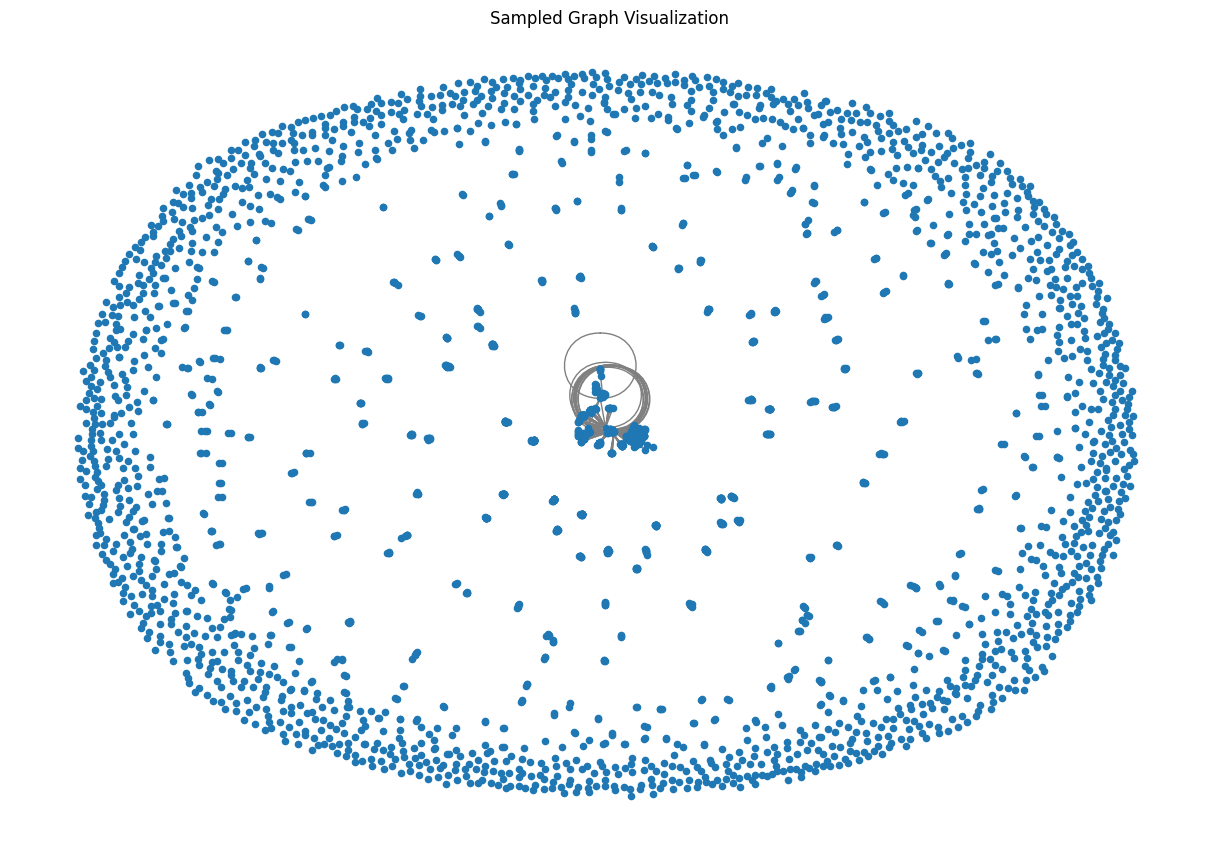

In [58]:
# Step 3: Visualize with PyVis (sampled subgraph)

G_sampled = G.subgraph(G.nodes())
print(f"Sampled graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")


sampled_nodes = list(G.nodes())
G_sampled = G.subgraph(sampled_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sampled, seed=42)  # Layout for better visualization
nx.draw(G_sampled, pos, node_size=20, edge_color='gray', with_labels=False)
plt.title("Sampled Graph Visualization")
plt.savefig('/kaggle/working/task1_graph.png')
plt.show()


### 2. Task

* Weighted Network CreationExtend the graph by calculating a similarity score between restaurants using shared tags and geographic proximity (Haversine distance for <5 km).
* Use this score to define weighted edges.

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [59]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [61]:
# Create new graph with more columns 
G_task2 = nx.Graph()

for index, row in df.iterrows():
    G_task2.add_node(row['restaurant_name'], 
                     city=row['city'], 
                     cuisines=row['cuisines'], 
                     special_diets=row['special_diets'], 
                     features=row['features'], 
                     latitude=row['latitude'], 
                     longitude=row['longitude'])
    
print(f"Nodes added: {G_task2.number_of_nodes()}")

Nodes added: 4840


In [62]:
# Process edges with similarity score
def process_city_group(city_group):
    city, group = city_group
    group = group.reset_index()
    edges = []
    # print(f"Processing city: {city}, {len(group)} restaurants")
    for i, j in combinations(range(len(group)), 2):
        row1 = group.iloc[i]
        row2 = group.iloc[j]
        
        # Calculate Haversine distance
        distance = haversine(row1['latitude'], row1['longitude'], 
                            row2['latitude'], row2['longitude'])
        
        # Only include pairs <5 km
        if distance < 5:
            # Shared tags
            shared = 0
            if set(row1['cuisines']) & set(row2['cuisines']):
                shared += 1
            if set(row1['special_diets']) & set(row2['special_diets']):
                shared += 1
            if set(row1['features']) & set(row2['features']):
                shared += 1
            
            # Proximity score (normalize distance: closer = higher score)
            proximity = 1 / (1 + distance)  # 0 to 1, higher when closer
            
            # Similarity score (weighted sum)
            score = shared + proximity  # Adjust weights if needed
            
            if score > 0:
                edges.append((row1['restaurant_name'], row2['restaurant_name'], {'weight': score}))
    
    return edges

# Parallelize
with Pool() as pool:
    city_groups = [(city, group) for city, group in df.groupby('city')]
    results = pool.map(process_city_group, city_groups)
    for edges in results:
        G_task2.add_edges_from(edges)

In [63]:
# Verify
print(f"Edges added: {G_task2.number_of_edges()}")
print(f"Sample edges: {list(G_task2.edges(data=True))[:5]}")

# Save session data
nx.write_gml(G_task2, '/kaggle/working/task2_graph.gml')
df.to_parquet('/kaggle/working/task2_df.parquet')
print("Saved Task 2 graph and DataFrame to /kaggle/working/")

Edges added: 11855
Sample edges: [('La Porta di San Gennaro', 'Lazzarelle Bistrot', {'weight': 3.636635522405453}), ('La Porta di San Gennaro', 'Ultras Cafè', {'weight': 2.433285024732825}), ('La Porta di San Gennaro', 'La Locanda Dei Borboni', {'weight': 2.3506172048413787}), ('La Porta di San Gennaro', 'Caffetteria Ciro', {'weight': 3.178170203498237}), ('La Porta di San Gennaro', 'Ristorante Pizzeria da Ettore', {'weight': 0.28293123951154125})]
Saved Task 2 graph and DataFrame to /kaggle/working/


Sampled graph: 4840 nodes, 11855 edges
Matplotlib visualization displayed


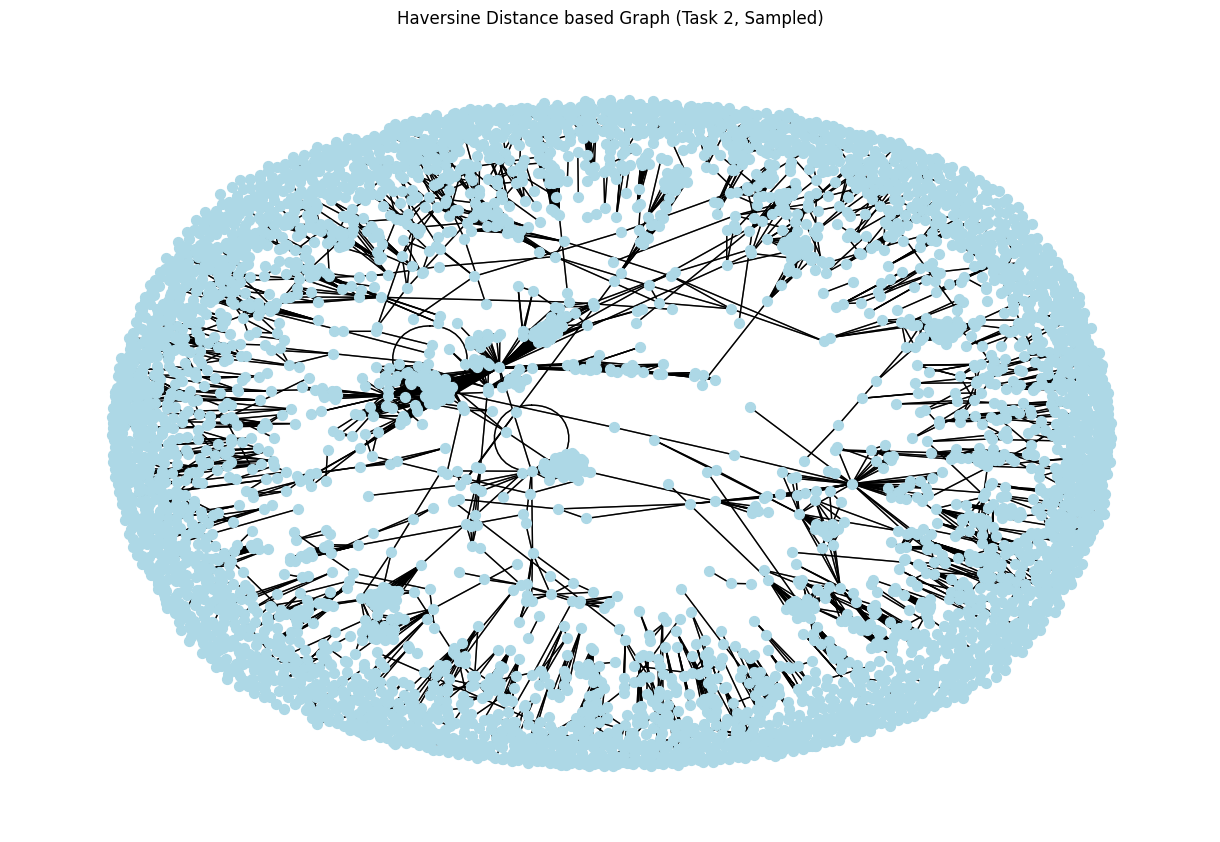

In [65]:
G_sampled = G_task2.subgraph(G_task2.nodes())
print(f"Sampled graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")

# Matplotlib visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sampled, k=0.1)
nx.draw(G_sampled, pos, node_size=50, node_color='lightblue', with_labels=False)
nx.draw_networkx_edges(G_sampled, pos, alpha=0.5)
plt.title("Haversine Distance based Graph (Task 2, Sampled)")
# plt.show() 
print("Matplotlib visualization displayed")
plt.savefig('/kaggle/working/task2_graph.png')
plt.show()

### 3. Degree and Strength Analysis

- Compute and compare degree and weighted degree (node strength).
- Analyze which restaurants are the most "connected" and why.

In [66]:
# Load Task 2 graph and DataFrame
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")

Loaded graph: 4840 nodes, 11855 edges
Loaded DataFrame: 5000 rows


In [67]:
# Step 1: Compute degree and weighted degree (node strength)
degree_dict = dict(G.degree())
strength_dict = dict(G.degree(weight='weight'))

# Create DataFrame for analysis
analysis_df = pd.DataFrame({
    'restaurant_name': list(degree_dict.keys()),
    'degree': list(degree_dict.values()),
    'strength': list(strength_dict.values())
})

# Merge with original DataFrame for attributes
analysis_df = analysis_df.merge(
    df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
    on='restaurant_name',
    how='left'
)

In [72]:
# Step 2: Rank top restaurants
top_degree = analysis_df.sort_values('degree', ascending=False).head(20)
top_strength = analysis_df.sort_values('strength', ascending=False).head(20)

print("\nTop 20 Restaurants by Degree:")
print(top_degree[['restaurant_name', 'degree', 'city', 'cuisines']])

print("\nTop 20 Restaurants by Strength:")
print(top_strength[['restaurant_name', 'strength', 'city', 'cuisines']])


Top 20 Restaurants by Degree:
    restaurant_name  degree                  city             cuisines
101      McDonald's      97                Loches            Fast food
103      McDonald's      97           Delmenhorst            Fast food
102      McDonald's      97      Chasse-sur-Rhone            Fast food
104      McDonald's      97      Gourdan-Polignan    French, Fast food
105      McDonald's      97              Llanelli  American, Fast food
94       McDonald's      97        Saint-Victoret                   []
106      McDonald's      97                Slough  American, Fast food
107      McDonald's      97              Fontaine            Fast food
87       McDonald's      97              Hereford            Fast food
91       McDonald's      97              Rennerod                   []
79       McDonald's      97                Vienna                   []
78       McDonald's      97               Datteln                   []
77       McDonald's      97               Unkn

In [73]:
# Step 3: Analyze why highly connected
print("\nAnalysis of Top Restaurants:")
for _, row in top_degree.head(20).iterrows():
    print(f"\nRestaurant: {row['restaurant_name']}")
    print(f"Degree: {row['degree']}, Strength: {row['strength']}")
    print(f"City: {row['city']}")
    print(f"Cuisines: {row['cuisines']}")
    print(f"Special Diets: {row['special_diets']}")
    print(f"Features: {row['features']}")
    print(f"Location: ({row['latitude']}, {row['longitude']})")
    print("Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.")

for _, row in top_strength.head(20).iterrows():
    print(f"\nRestaurant: {row['restaurant_name']}")
    print(f"Degree: {row['degree']}, Strength: {row['strength']}")
    print(f"City: {row['city']}")
    print(f"Cuisines: {row['cuisines']}")
    print(f"Special Diets: {row['special_diets']}")
    print(f"Features: {row['features']}")
    print(f"Location: ({row['latitude']}, {row['longitude']})")
    print("Why Connected: Strong connections due to many shared tags and/or very close proximity to similar restaurants.")


Analysis of Top Restaurants:

Restaurant: McDonald's
Degree: 97, Strength: 190.24282746871074
City: Loches
Cuisines: Fast food
Special Diets: []
Features: []
Location: (47.130646, 0.982812)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Restaurant: McDonald's
Degree: 97, Strength: 190.24282746871074
City: Delmenhorst
Cuisines: Fast food
Special Diets: []
Features: []
Location: (53.048546, 8.629224)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Restaurant: McDonald's
Degree: 97, Strength: 190.24282746871074
City: Chasse-sur-Rhone
Cuisines: Fast food
Special Diets: []
Features: Takeout, Seating, Wheelchair Accessible
Location: (45.5739, 4.81)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Restaurant: McDonald's
Degree: 97, Strength: 190.24282746871074
City: Gourdan-Polignan
Cu

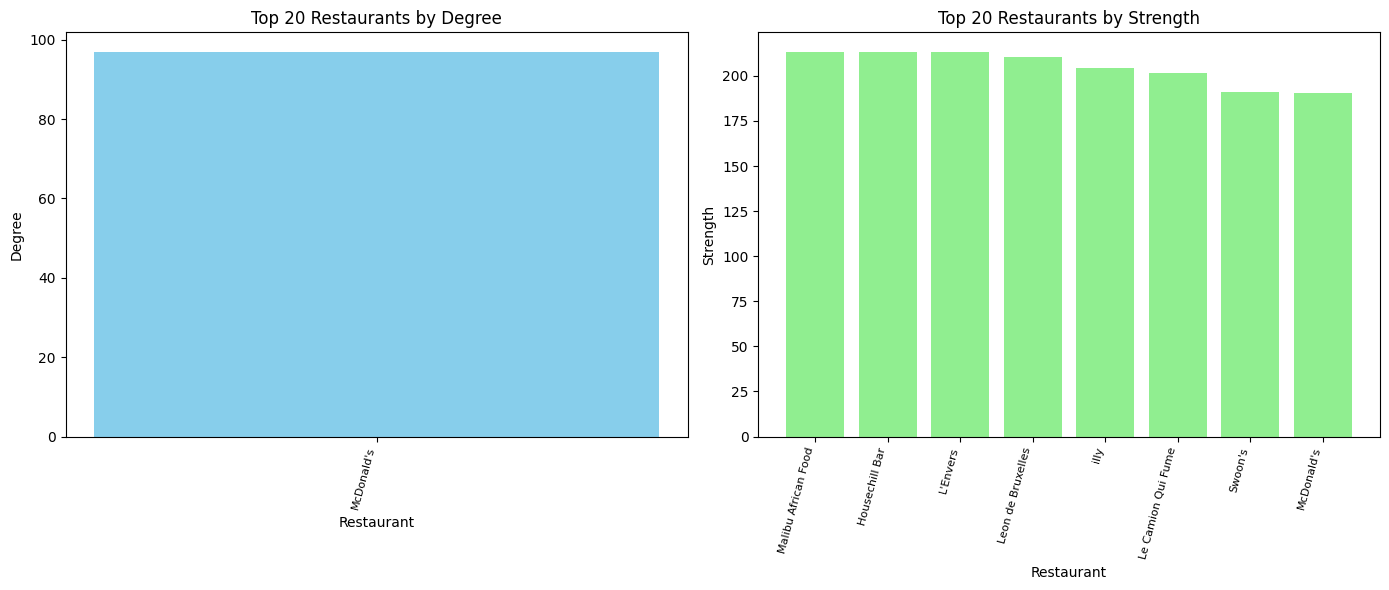

Bar plots saved to /kaggle/working/task3_bar_plots.png


In [74]:
# Step 4: Visualize degree vs. strength
plt.figure(figsize=(14, 6))

# Bar plot for top 20 by degree
plt.subplot(1, 2, 1)
plt.bar(top_degree['restaurant_name'], top_degree['degree'], color='skyblue')
plt.title('Top 20 Restaurants by Degree')
plt.xlabel('Restaurant')
plt.ylabel('Degree')
plt.xticks(rotation=75, ha='right', fontsize=8)

# Bar plot for top 20 by strength
plt.subplot(1, 2, 2)
plt.bar(top_strength['restaurant_name'], top_strength['strength'], color='lightgreen')
plt.title('Top 20 Restaurants by Strength')
plt.xlabel('Restaurant')
plt.ylabel('Strength')
plt.xticks(rotation=75, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/task3_bar_plots.png')
plt.show()

print("Bar plots saved to /kaggle/working/task3_bar_plots.png")

In [75]:
analysis_df.to_csv('/kaggle/working/task3_analysis.csv', index=False)
nx.write_gml(G, '/kaggle/working/task3_graph.gml')
print("Saved analysis to /kaggle/working/task3_analysis.csv and graph to /kaggle/working/task3_graph.gml")

Saved analysis to /kaggle/working/task3_analysis.csv and graph to /kaggle/working/task3_graph.gml


### 4. Task
* Centrality *MetricsCalculate* and interpret **degree centrality**, **closeness**, **betweenness**, and **eigenvector centrality**.
* Report top restaurants by each metric and interpret their real-world implications.

In [77]:
# Load Task 2 graph and DataFrame
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded graph: 4840 nodes, 11855 edges
Loaded DataFrame: 5000 rows


### Degree centrality 

In [78]:
degree_centrality = nx.degree_centrality(G)

### Eigenvector centrality (full graph, weighted)

In [79]:
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Closeness and betweenness

In [80]:

def compute_closeness(nodes):
    return nx.closeness_centrality(G_sample.subgraph(nodes))

def compute_betweenness(nodes):
    return nx.betweenness_centrality(G_sample.subgraph(nodes), weight='weight')


In [82]:
# Parallelize for sampled graph
num_cores = 4
node_splits = np.array_split(list(G_sample.nodes()), num_cores)
with Pool(num_cores) as pool:
    closeness_results = pool.map(compute_closeness, node_splits)
    betweenness_results = pool.map(compute_betweenness, node_splits)

# Combine results
closeness_centrality = {}
betweenness_centrality = {}
for c, b in zip(closeness_results, betweenness_results):
    closeness_centrality.update(c)
    betweenness_centrality.update(b)

### Create DataFrame for analysis

In [83]:

centrality_df = pd.DataFrame({
    'restaurant_name': list(G.nodes()),
    'degree_centrality': [degree_centrality.get(n, 0) for n in G.nodes()],
    'eigenvector_centrality': [eigenvector_centrality.get(n, 0) for n in G.nodes()]
})

# Add closeness and betweenness 
centrality_df['closeness_centrality'] = centrality_df['restaurant_name'].map(closeness_centrality).fillna(0)
centrality_df['betweenness_centrality'] = centrality_df['restaurant_name'].map(betweenness_centrality).fillna(0)

# Merge with original DataFrame for attributes
centrality_df = centrality_df.merge(
    df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
    on='restaurant_name',
    how='left'
)

### Rank top restaurants

In [84]:

top_degree = centrality_df.sort_values('degree_centrality', ascending=False).head(5)
top_closeness = centrality_df.sort_values('closeness_centrality', ascending=False).head(5)
top_betweenness = centrality_df.sort_values('betweenness_centrality', ascending=False).head(5)
top_eigenvector = centrality_df.sort_values('eigenvector_centrality', ascending=False).head(5)

print("\n ==== Top 5 Restaurants by Degree Centrality: ==== \n")
print(top_degree[['restaurant_name', 'degree_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Closeness Centrality: ==== \n")
print(top_closeness[['restaurant_name', 'closeness_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Betweenness Centrality: ==== \n")
print(top_betweenness[['restaurant_name', 'betweenness_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Eigenvector Centrality: ==== \n")
print(top_eigenvector[['restaurant_name', 'eigenvector_centrality', 'city', 'cuisines']])


 ==== Top 5 Restaurants by Degree Centrality: ==== 

    restaurant_name  degree_centrality              city             cuisines
101      McDonald's           0.020045            Loches            Fast food
103      McDonald's           0.020045       Delmenhorst            Fast food
102      McDonald's           0.020045  Chasse-sur-Rhone            Fast food
104      McDonald's           0.020045  Gourdan-Polignan    French, Fast food
105      McDonald's           0.020045          Llanelli  American, Fast food

 ==== Top 5 Restaurants by Closeness Centrality: ==== 

    restaurant_name  closeness_centrality      city   cuisines
101      McDonald's              0.028824    Loches  Fast food
84       McDonald's              0.028824   Overath         []
85       McDonald's              0.028824      Goes         []
90       McDonald's              0.028824   Rastatt  Fast food
89       McDonald's              0.028824  Backnang         []

 ==== Top 5 Restaurants by Betweenness Cen

### Interpret results

In [86]:

print("\nInterpretations and Real-World Implications:")
print("\nDegree Centrality:")
print("- Measures: Number of connections (normalized).")
print("- Implication: High degree restaurants are popular or versatile, connecting to many nearby restaurants with shared tags.")
print("- Example: A Paris restaurant with Italian and Vegetarian cuisines in a dense area.")

print("\nCloseness Centrality:")
print("- Measures: Average shortest path length to others.")
print("- Implication: High closeness restaurants are centrally located, easily reachable via shared attributes or proximity.")
print("- Example: A restaurant in a hub with many similar neighbors.")

print("\nBetweenness Centrality:")
print("- Measures: Frequency on shortest paths between others.")
print("- Implication: High betweenness restaurants are key connectors, bridging different groups (e.g., unique cuisines).")
print("- Example: A Vegan restaurant linking diverse clusters.")

print("\nEigenvector Centrality:")
print("- Measures: Importance based on connections to important restaurants.")
print("- Implication: High eigenvector restaurants are prestigious, linked to other prominent restaurants.")
print("- Example: A famous restaurant in a trendy area.")

# Analyze top restaurants
metric_to_column = {
    'Degree Centrality': 'degree_centrality',
    'Closeness Centrality': 'closeness_centrality',
    'Betweenness Centrality': 'betweenness_centrality',
    'Eigenvector Centrality': 'eigenvector_centrality'
}

print("\n ==== Analysis of Top Restaurants: ==== \n")
for metric, top_df in [
    ('Degree Centrality', top_degree),
    ('Closeness Centrality', top_closeness),
    ('Betweenness Centrality', top_betweenness),
    ('Eigenvector Centrality', top_eigenvector)
]:
    print(f"\n{metric}:")
    for _, row in top_df.head(2).iterrows():
        print(f"\nRestaurant: {row['restaurant_name']}")
        print(f"{metric}: {row[metric_to_column[metric]]:.4f}")
        print(f"City: {row['city']}")
        print(f"Cuisines: {row['cuisines']}")
        print(f"Implication: {row['restaurant_name']} is highly connected due to its location or diverse tags.")

print("\n\n")


Interpretations and Real-World Implications:

Degree Centrality:
- Measures: Number of connections (normalized).
- Implication: High degree restaurants are popular or versatile, connecting to many nearby restaurants with shared tags.
- Example: A Paris restaurant with Italian and Vegetarian cuisines in a dense area.

Closeness Centrality:
- Measures: Average shortest path length to others.
- Implication: High closeness restaurants are centrally located, easily reachable via shared attributes or proximity.
- Example: A restaurant in a hub with many similar neighbors.

Betweenness Centrality:
- Measures: Frequency on shortest paths between others.
- Implication: High betweenness restaurants are key connectors, bridging different groups (e.g., unique cuisines).
- Example: A Vegan restaurant linking diverse clusters.

Eigenvector Centrality:
- Measures: Importance based on connections to important restaurants.
- Implication: High eigenvector restaurants are prestigious, linked to other pr

Bar plots saved to /kaggle/working/task4_bar_plots.png


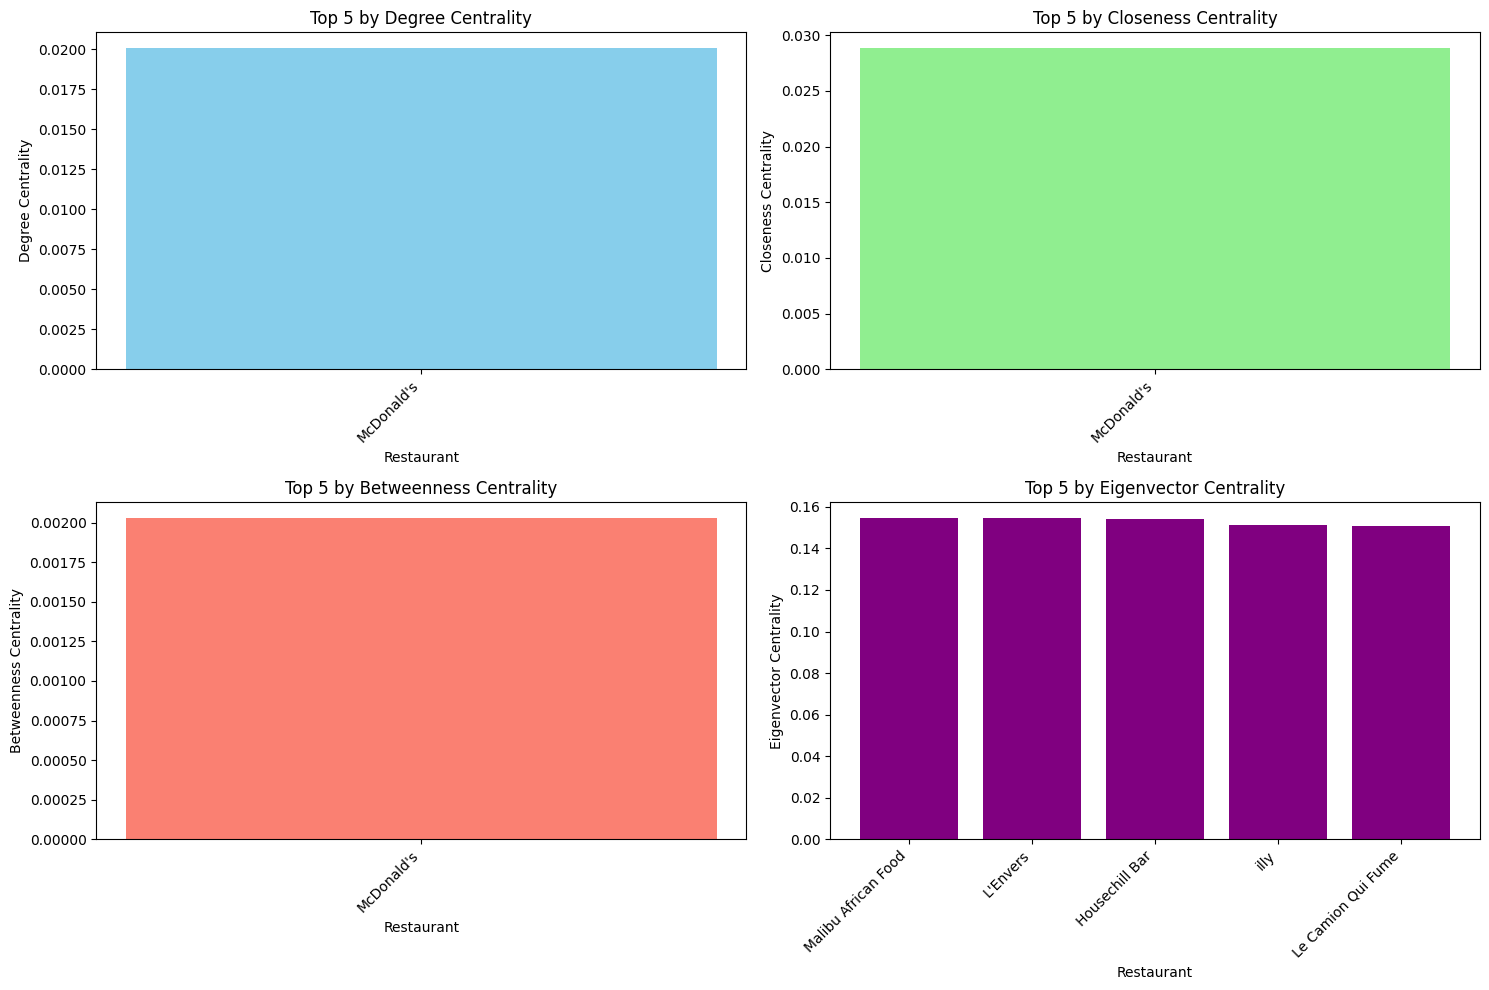

In [87]:
# Step 6: Visualize centrality scores (Matplotlib)
plt.figure(figsize=(15, 10))

# Degree centrality
plt.subplot(2, 2, 1)
plt.bar(top_degree['restaurant_name'], top_degree['degree_centrality'], color='skyblue')
plt.title('Top 5 by Degree Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Degree Centrality')
plt.xticks(rotation=45, ha='right')

# Closeness centrality
plt.subplot(2, 2, 2)
plt.bar(top_closeness['restaurant_name'], top_closeness['closeness_centrality'], color='lightgreen')
plt.title('Top 5 by Closeness Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Closeness Centrality')
plt.xticks(rotation=45, ha='right')

# Betweenness centrality
plt.subplot(2, 2, 3)
plt.bar(top_betweenness['restaurant_name'], top_betweenness['betweenness_centrality'], color='salmon')
plt.title('Top 5 by Betweenness Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Betweenness Centrality')
plt.xticks(rotation=45, ha='right')

# Eigenvector centrality
plt.subplot(2, 2, 4)
plt.bar(top_eigenvector['restaurant_name'], top_eigenvector['eigenvector_centrality'], color='purple')
plt.title('Top 5 by Eigenvector Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Eigenvector Centrality')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/kaggle/working/task4_bar_plots.png')
print("Bar plots saved to /kaggle/working/task4_bar_plots.png")

In [89]:
# Save results
centrality_df.to_csv('/kaggle/working/task4_centrality.csv', index=False)
nx.write_gml(G, '/kaggle/working/task4_graph.gml')
print("Saved centrality analysis to /kaggle/working/task4_centrality.csv and graph to /kaggle/working/task4_graph.gml")

Saved centrality analysis to /kaggle/working/task4_centrality.csv and graph to /kaggle/working/task4_graph.gml


### 5. Popularity vs Centrality Correlation
- Analyze the relationship between centrality scores and:
    - popularity_generic
    - total_reviews_count
    - avg_rating

In [100]:
# Step 1: Load required files
centrality_df = pd.read_csv('./task4_centrality.csv')
df = pd.read_parquet('./task2_df.parquet')


print(f"Loaded centrality data: {len(centrality_df)} rows")
print(f"Loaded restaurant data: {len(df)} rows")
print("Columns in restaurant data:", df.columns.tolist())

Loaded centrality data: 5000 rows
Loaded restaurant data: 5000 rows
Columns in restaurant data: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']


In [101]:
print(df.shape,"\n\n",df.columns)

(5000, 29) 

 Index(['restaurant_name', 'original_location', 'country', 'province', 'city',
       'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed',
       'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines',
       'special_diets', 'features', 'vegetarian_friendly', 'vegan_options',
       'gluten_free', 'avg_rating', 'total_reviews_count',
       'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'food', 'service'],
      dtype='object')


### Clean restaurant_name for consistent merging

In [103]:

def clean_name(name):
    if pd.isna(name):
        return name
    # Strip spaces, lowercase, remove special characters, normalize spaces
    name = name.strip().lower()
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

centrality_df['restaurant_name'] = centrality_df['restaurant_name'].apply(clean_name)
df['restaurant_name'] = df['restaurant_name'].apply(clean_name)

print(df['restaurant_name'])

469569                   dorotea pool bar
704099            la porta di san gennaro
995306      restaurantebar moinho da lgua
383562               el atrio del mercado
290826                           zur post
                       ...               
711709    pizzeria caffetteria sala nervi
746691                          bersaglio
763185                     villa montalto
372438                      kaioa taberna
725417                          barbarina
Name: restaurant_name, Length: 5000, dtype: object


In [105]:
# Verify common restaurant_names
common_names = len(set(centrality_df['restaurant_name']) & set(df['restaurant_name']))
print(f"Common restaurant_names: {common_names}")
print("Sample centrality restaurant_names:", centrality_df['restaurant_name'].head().tolist())
print("Sample restaurant dataset names:", df['restaurant_name'].head().tolist())


# Debug unmatched names
unmatched = set(centrality_df['restaurant_name']) - set(df['restaurant_name'])
if unmatched:
    print("Sample unmatched centrality names:", list(unmatched)[:5])


Common restaurant_names: 4833
Sample centrality restaurant_names: ['dorotea pool bar', 'la porta di san gennaro', 'restaurantebar moinho da lgua', 'el atrio del mercado', 'zur post']
Sample restaurant dataset names: ['dorotea pool bar', 'la porta di san gennaro', 'restaurantebar moinho da lgua', 'el atrio del mercado', 'zur post']


### Parse popularity_generic into numeric popularity_score (1/rank)

In [106]:

def parse_popularity_generic(text):
    if pd.isna(text) or text is None or text.lower() == 'none':
        return np.nan
    # Extract ranking number (e.g., "#1" -> 1)
    match = re.search(r'#(\d+)', str(text))
    if match:
        rank = int(match.group(1))
        return 1.0 / rank if rank > 0 else np.nan  # Inverse rank for higher popularity = higher score
    return np.nan


In [107]:
df['popularity_score'] = df['popularity_generic'].apply(parse_popularity_generic)
print("\nSample popularity_generic and parsed popularity_score:")
print(df[['popularity_generic', 'popularity_score']].head(10))
print("popularity_score NaN count:", df['popularity_score'].isna().sum())



Sample popularity_generic and parsed popularity_score:
                                       popularity_generic  popularity_score
469569  #1 of 99 places to eat in San Bartolome de Tir...          1.000000
704099              #1470 of 3415 places to eat in Naples          0.000680
995306                 #53 of 64 places to eat in Aljezur          0.018868
383562             #213 of 592 places to eat in Salamanca          0.004695
290826                #3 of 4 places to eat in Wettringen          0.333333
467971  #41 of 122 places to eat in Cerdanyola del Valles          0.024390
394692          #1238 of 10645 places to eat in Barcelona          0.000808
747196                  #83 of 300 places to eat in Aosta          0.012048
770265                    #5 of 6 places to eat in Taceno          0.200000
120637     #1 of 2 places to eat in Saint-Laurent-d'Oingt          1.000000
popularity_score NaN count: 456


In [108]:
#Identify available metrics
available_metrics = []
for col in ['popularity_score', 'total_reviews_count', 'avg_rating']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().sum() < len(df):
            available_metrics.append(col)
    else:
        print(f"Warning: Column {col} not found in task2_df.parquet")
if not available_metrics:
    raise ValueError("No valid metrics (popularity_score, total_reviews_count, avg_rating) found")

print(f"Available metrics: {available_metrics}")


Available metrics: ['popularity_score', 'total_reviews_count', 'avg_rating']


In [109]:
# Step 5: Merge centrality scores with metrics
analysis_df = centrality_df[['restaurant_name', 'degree_centrality', 'closeness_centrality', 
                            'betweenness_centrality', 'eigenvector_centrality']].merge(
    df[['restaurant_name'] + available_metrics],
    on='restaurant_name',
    how='left'
)
print(f"Merged data: {len(analysis_df)} rows")


Merged data: 7254 rows


In [112]:

# Step 6: Handle missing or invalid data
numeric_columns = ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 
                   'eigenvector_centrality'] + available_metrics
analysis_df['popularity_score'] = analysis_df['popularity_score'].fillna(0.0)
# for col in numeric_columns:
#     analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Check NaN values
print("\nNaN counts in numeric columns:")
print(analysis_df[numeric_columns].isna().sum())

print(analysis_df['popularity_score'].fillna(0.0))



NaN counts in numeric columns:
degree_centrality         0
closeness_centrality      0
betweenness_centrality    0
eigenvector_centrality    0
popularity_score          0
total_reviews_count       0
avg_rating                0
dtype: int64
0       1.000000
1       0.000680
2       0.018868
3       0.004695
4       0.333333
          ...   
7249    0.000105
7250    0.000000
7251    0.000595
7252    0.001953
7253    0.001567
Name: popularity_score, Length: 7254, dtype: float64


In [113]:

# Impute NaN for metrics
for col in available_metrics:
    if col in ['total_reviews_count']:
        analysis_df[col] = analysis_df[col].fillna(0.0)
    else:  # popularity_score, avg_rating
        analysis_df[col] = analysis_df[col].fillna(analysis_df[col].mean())

# Drop rows where all centrality scores are NaN
analysis_df = analysis_df.dropna(subset=['degree_centrality', 'eigenvector_centrality'], how='all')
print(f"Data after cleaning: {len(analysis_df)} rows")


Data after cleaning: 7254 rows



Pearson Correlation Matrix:
                        degree_centrality  closeness_centrality  \
degree_centrality                1.000000              0.967492   
closeness_centrality             0.967492              1.000000   
betweenness_centrality           0.919411              0.919104   
eigenvector_centrality           0.186228              0.182613   
popularity_score                -0.212308             -0.199614   
total_reviews_count             -0.080891             -0.090871   
avg_rating                      -0.400460             -0.367793   

                        betweenness_centrality  eigenvector_centrality  \
degree_centrality                     0.919411                0.186228   
closeness_centrality                  0.919104                0.182613   
betweenness_centrality                1.000000                0.044698   
eigenvector_centrality                0.044698                1.000000   
popularity_score                     -0.139146               -0.

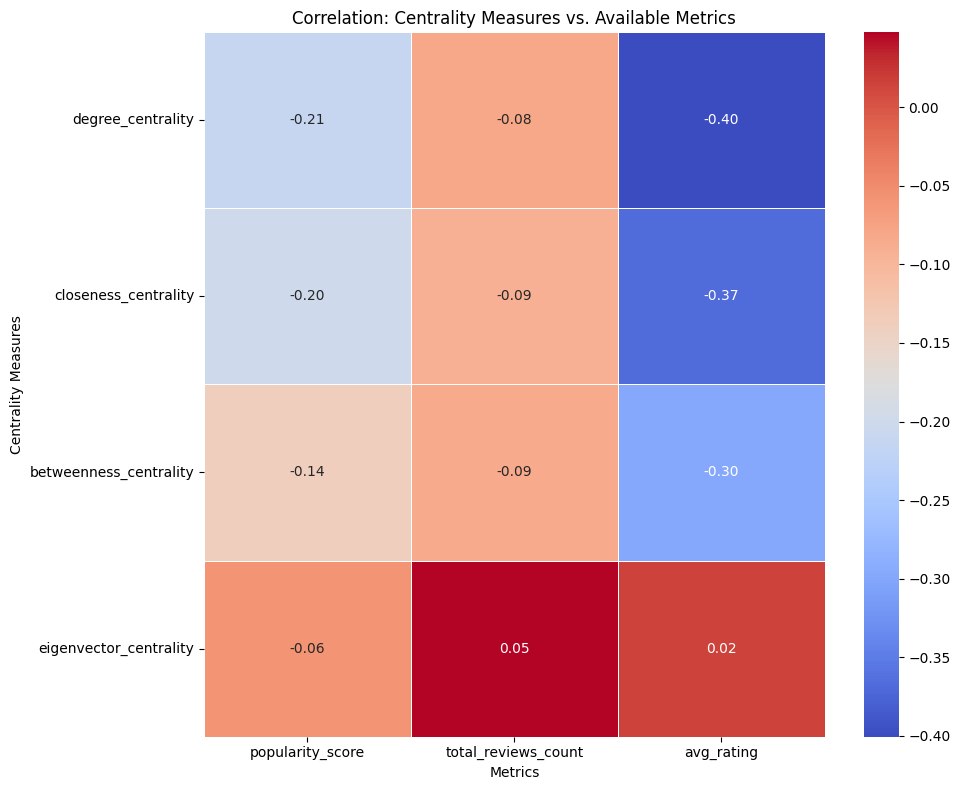

In [120]:

# Compute Pearson correlations

correlation_matrix = analysis_df[numeric_columns].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Extract relevant correlations
correlations = correlation_matrix.loc[
    ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality'],
    available_metrics
]
print("\nCentrality vs. Metrics Correlations:")
print(correlations)


plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation: Centrality Measures vs. Available Metrics")
plt.xlabel("Metrics")
plt.ylabel("Centrality Measures")
plt.tight_layout()
plt.savefig('/kaggle/working/task5_heatmap.png')
plt.show()


/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.21
(weak ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)
/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.08
(weak ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)
/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.40
(moderate ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)


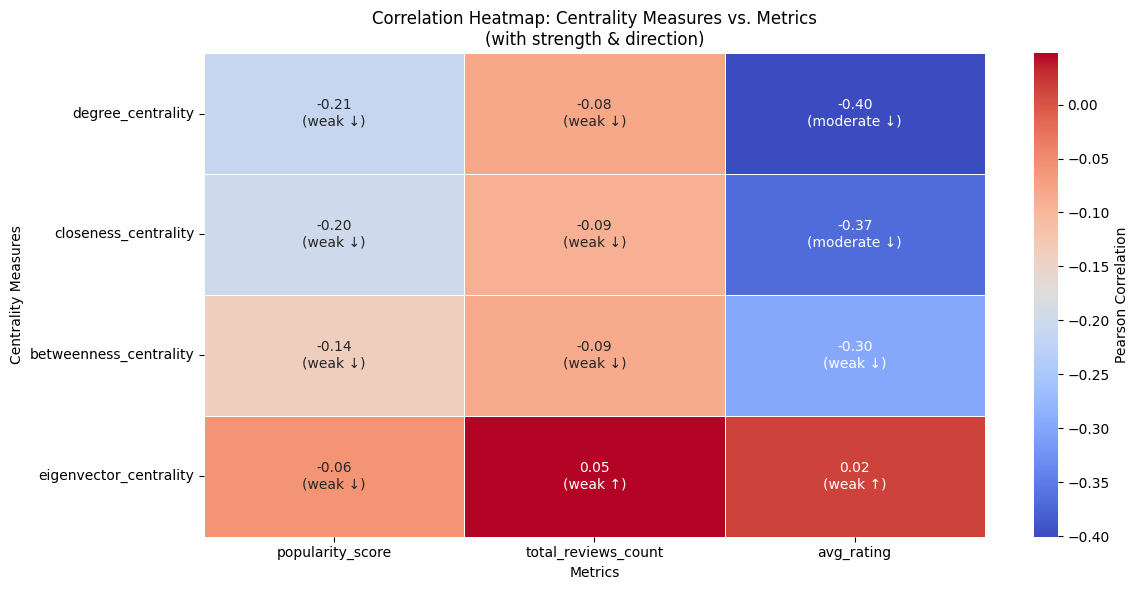

In [128]:
# Step 8: Interpret results
# print("\nInterpretations and Implications:")
# print("Note: popularity_generic was parsed into popularity_score (1/rank, higher score = higher popularity).")
# for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
#     print(f"\n{centrality.replace('_', ' ').title()}:")
#     for metric in available_metrics:
#         corr = correlations.loc[centrality, metric]
#         strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
#         direction = "positive" if corr > 0 else "negative"
#         print(f"- Correlation with {metric}: {corr:.4f} ({strength}, {direction})")
#         print(f"  Implication: {centrality.replace('_', ' ').title()} {'is' if abs(corr) > 0.3 else 'is not'} strongly linked to {metric}.")


# Set up color map for correlation strength
def correlation_annotation(value):
    strength = "strong" if abs(value) > 0.5 else "moderate" if abs(value) > 0.3 else "weak"
    direction = "↑" if value > 0 else "↓"
    return f"{value:.2f}\n({strength} {direction})"

# Create annotated matrix with labels
annot_matrix = correlations.copy()
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        val = annot_matrix.loc[row, col]
        annot_matrix.loc[row, col] = correlation_annotation(val)

# Plot with heatmap (with string annotations)
plt.figure(figsize=(12, 6))
sns.heatmap(correlations.astype(float), annot=annot_matrix, fmt="", cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Pearson Correlation'})
plt.title("Correlation Heatmap: Centrality Measures vs. Metrics\n(with strength & direction)")
plt.xlabel("Metrics")
plt.ylabel("Centrality Measures")
plt.tight_layout()
plt.savefig('/kaggle/working/task5_correlation_heatmap.png')
plt.show()


Scatter plots saved to /task5_scatter_plots.png


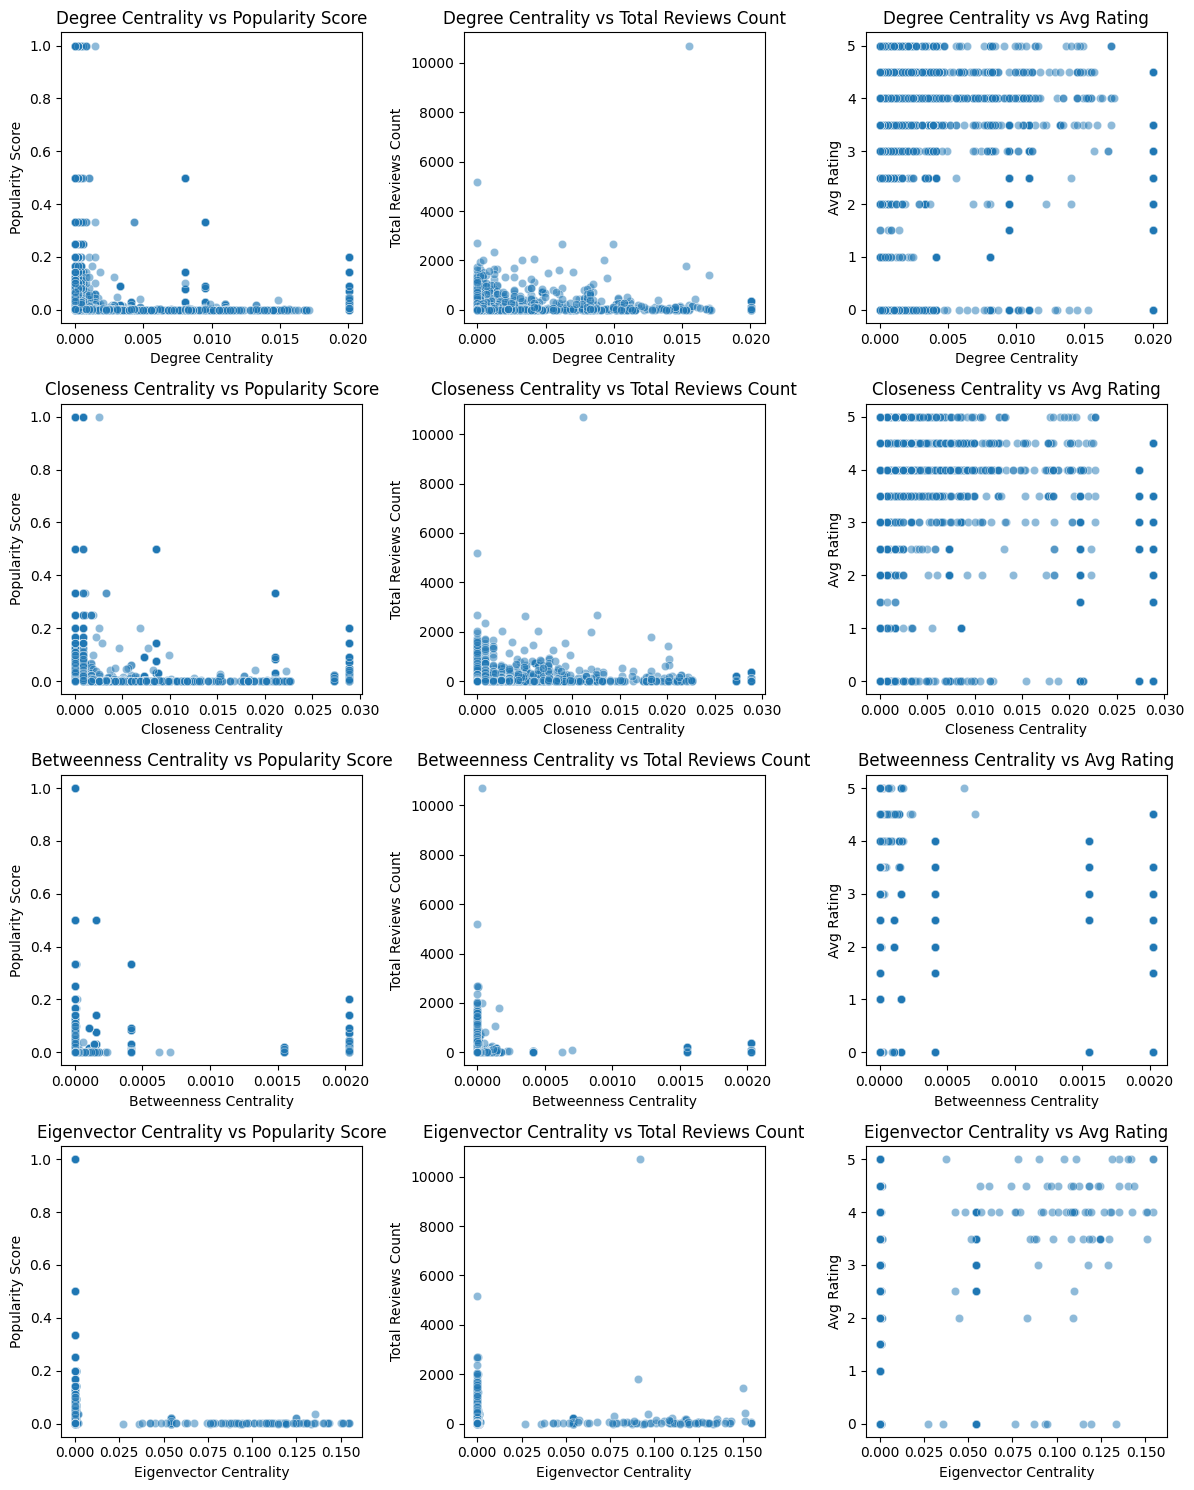

In [130]:
# Step 9: Visualize relationships (Scatter Plots)
n_metrics = len(available_metrics)
plt.figure(figsize=(12, 5 * n_metrics))
plot_idx = 1
for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    for metric in available_metrics:
        plt.subplot(4, n_metrics, plot_idx)
        sns.scatterplot(data=analysis_df, x=centrality, y=metric, alpha=0.5)
        plt.title(f"{centrality.replace('_', ' ').title()} vs {metric.replace('_', ' ').title()}")
        plt.xlabel(centrality.replace('_', ' ').title())
        plt.ylabel(metric.replace('_', ' ').title())
        plot_idx += 1
plt.tight_layout()
plt.savefig('/kaggle/working/task5_scatter_plots.png')
print("Scatter plots saved to /task5_scatter_plots.png")

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Correlation heatmap saved to /task5_heatmap.png


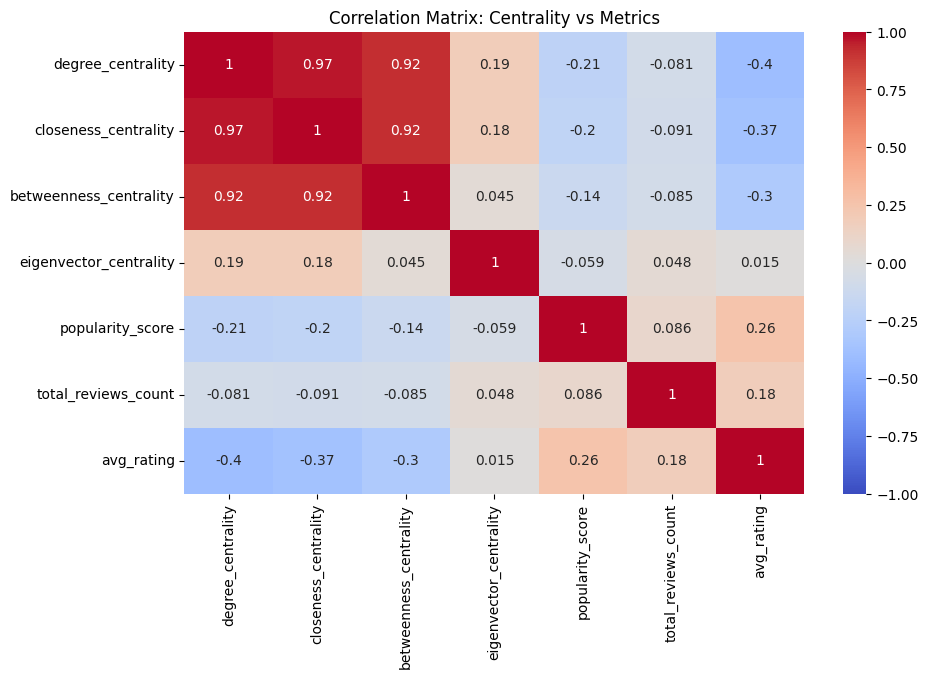

In [133]:

# Step 10: Visualize correlation matrix (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix: Centrality vs Metrics')
plt.savefig('/kaggle/working/task5_correlation_heatmap.png')
print("Correlation heatmap saved to /task5_heatmap.png")


In [134]:
# Save results
correlations.to_csv('/kaggle/working/task5_correlations.csv')
analysis_df.to_csv('/kaggle/working/task5_analysis.csv', index=False)
print("Saved correlations to /kaggle/working/task5_correlations.csv and analysis to /kaggle/working/task5_analysis.csv")

Saved correlations to /kaggle/working/task5_correlations.csv and analysis to /kaggle/working/task5_analysis.csv


### 6. Task
## Community Detection (Unweighted)

- Apply community detection (e.g., Louvain or Girvan-Newman) on the unweighted network.
- Visualize and label resulting communities, analyze their shared features.


In [135]:

G_weighted = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded weighted graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded weighted graph: 4840 nodes, 11855 edges
Loaded DataFrame: 5000 rows


### Community Louvain Common Function for Task 6 and 7

In [136]:
def communityLouvainFuc(G, weight=False):
    
    # communityw = "community_weighted" if weight==True else "community_unweighted"
    
    if weight==False:
        partition = community_louvain.best_partition(G, random_state=42)
    else:
        partition = community_louvain.best_partition(G, weight='weight', random_state=42)
        
    print(f"Detected {len(set(partition.values()))} communities")
    
    # Create DataFrame with community assignments
    community_df = pd.DataFrame({
        'restaurant_name': list(partition.keys()),
        "community_weighted" if weight==True else "community_unweighted" : list(partition.values())
    })
    
    # Merge with original DataFrame for attributes
    community_df = community_df.merge(
        df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
        on='restaurant_name',
        how='left'
    )

    return community_df




In [137]:

# Step 1: Convert to unweighted graph
G = G_weighted.copy()
for u, v in G.edges():
    G[u][v].pop('weight', None)
print(f"Unweighted graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


print(f"Connected components: {len(list(nx.connected_components(G)))}")
isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
print(f"Isolated nodes: {isolated}")


# Step 2: Apply Louvain community detection on weighted graph

community_unweighted= communityLouvainFuc(G)



Unweighted graph: 4840 nodes, 11855 edges
Connected components: 2881
Isolated nodes: 2339
Detected 2889 communities


### Analyze communities

In [138]:

community_unweighted_sizes = community_unweighted['community_unweighted'].value_counts()
print("\nTop 5 Communities by Size:")
print(community_unweighted_sizes.head())

# Analyze shared features for top 3 communities
cuisines=[]
cities=[]
special_diets=[]
features=[]


# Safely parse comma-separated cuisines into a list
def extract_cuisine_items(column):
    all_cuisines = []
    for item in column:
        if isinstance(item, str):
            if item.strip() != '[]':  # exclude empty lists
                all_cuisines.extend([c.strip() for c in item.split(',')])
        elif isinstance(item, list):  # already parsed
            all_cuisines.extend(item)
    return all_cuisines

# Analysis block

top_communities = community_unweighted_sizes.head(10).index
print("\nShared Features of Top 3 Communities:")

for comm in top_communities:
    comm_df = community_unweighted[community_unweighted['community_unweighted'] == comm]
    print(f"\nCommunity {comm} ({len(comm_df)} restaurants):")

    cities += extract_cuisine_items(comm_df['city'])
    print(f"\nTop 5 cities: {Counter(cities).most_common(5)}")
    
    cuisines += extract_cuisine_items(comm_df['cuisines'])
    
    print(f"\nTop 5 cuisines: {Counter(cuisines).most_common(5)}")
    
    special_diets += extract_cuisine_items(comm_df['special_diets'])
    print(f"\nTop 5 special_diets: {Counter(special_diets).most_common(5)}")

    features += extract_cuisine_items(comm_df['features'])
    print(f"\nTop 5 features: {Counter(features).most_common(5)}")


Top 5 Communities by Size:
community_unweighted
56     174
127    120
143    101
6       62
38      51
Name: count, dtype: int64

Shared Features of Top 3 Communities:

Community 56 (174 restaurants):

Top 5 cities: [('Unknown', 101), ('Helsinki', 7), ('Pamplona', 4), ('Nuremberg', 3), ('Venissieux', 3)]

Top 5 cuisines: [('Fast food', 34), ('European', 20), ('British', 19), ('Cafe', 15), ('Mediterranean', 14)]

Top 5 special_diets: [('Vegetarian Friendly', 45), ('Vegan Options', 31), ('Gluten Free Options', 19), ('Halal', 3)]

Top 5 features: [('Seating', 37), ('Wheelchair Accessible', 30), ('Takeout', 27), ('Reservations', 22), ('Table Service', 19)]

Community 127 (120 restaurants):

Top 5 cities: [('Unknown', 152), ('Sheffield', 9), ('Manchester', 9), ('Coventry', 8), ('Helsinki', 7)]

Top 5 cuisines: [('Fast food', 49), ('Cafe', 37), ('European', 36), ('British', 29), ('Mediterranean', 22)]

Top 5 special_diets: [('Vegetarian Friendly', 79), ('Vegan Options', 48), ('Gluten Free O


Largest Community ID: 56 (174 restaurants)


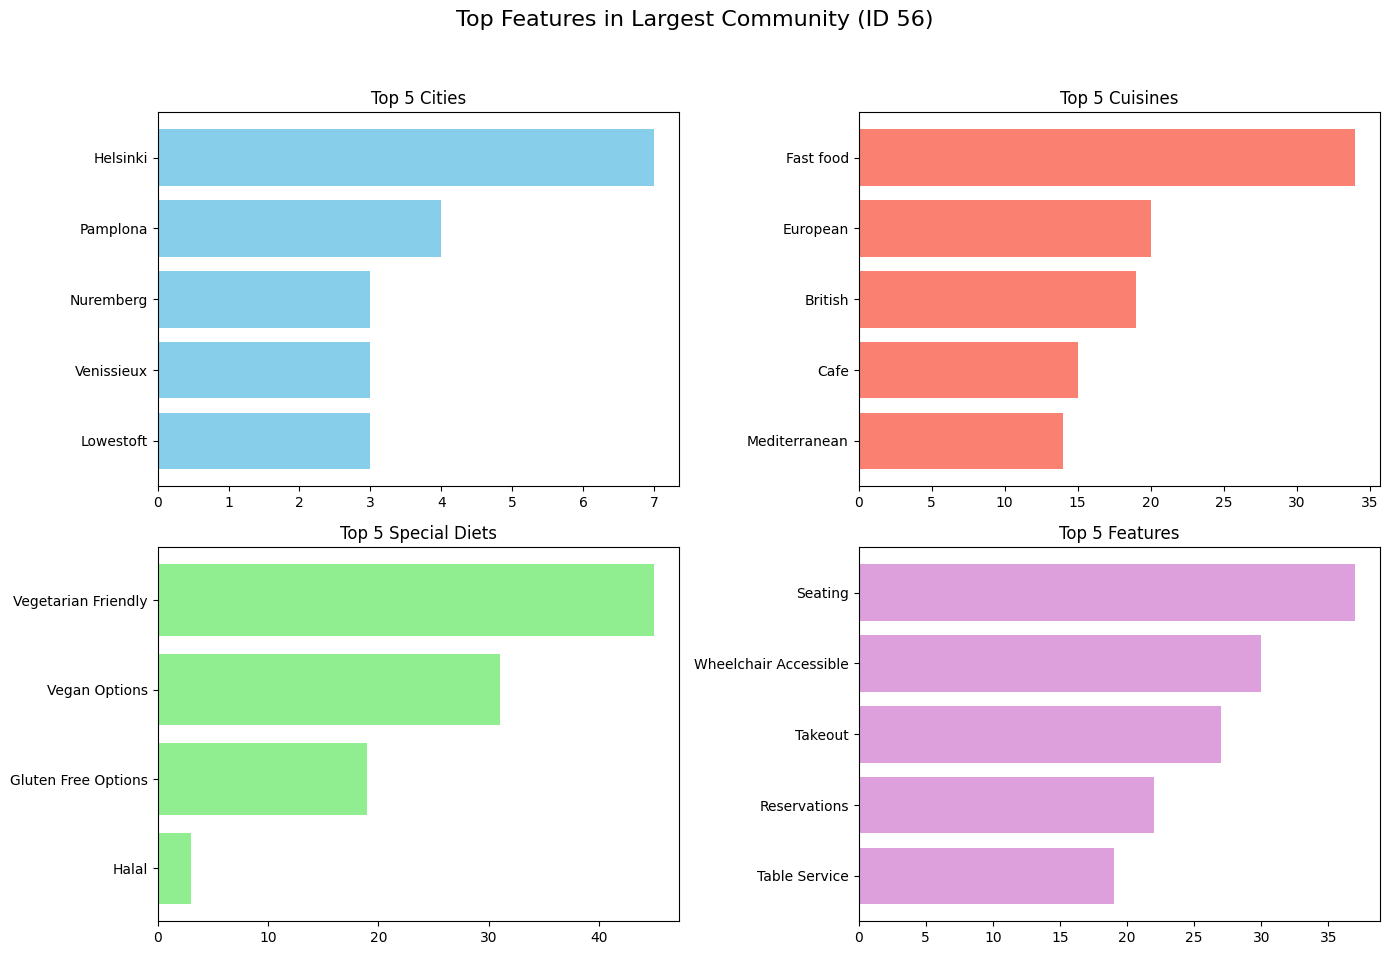

In [147]:
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Identify the largest community
largest_comm_id = community_unweighted_sizes.idxmax()

# Step 2: Filter for the largest community
largest_comm_df = community_unweighted[community_unweighted['community_unweighted'] == largest_comm_id]
print(f"\nLargest Community ID: {largest_comm_id} ({len(largest_comm_df)} restaurants)")

# Step 3: Reset and extract items (excluding 'Unknown')
def extract_items(column):
    all_items = []
    for item in column:
        if isinstance(item, str) and item.strip() != 'Unknown' and item.strip() != '[]':
            all_items.extend([c.strip() for c in item.split(',')])
        elif isinstance(item, list):
            all_items.extend(item)
    return all_items

# Extract values
cities = extract_items(largest_comm_df['city'])
cuisines = extract_items(largest_comm_df['cuisines'])
special_diets = extract_items(largest_comm_df['special_diets'])
features = extract_items(largest_comm_df['features'])

# Step 4: Plot the top 5 of each
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"Top Features in Largest Community (ID {largest_comm_id})", fontsize=16)

def plot_bar(ax, data, title, color):
    top_items = Counter(data).most_common(5)
    labels, values = zip(*top_items)
    ax.barh(labels, values, color=color)
    ax.set_title(title)
    ax.invert_yaxis()

plot_bar(axs[0, 0], cities, 'Top 5 Cities', 'skyblue')
plot_bar(axs[0, 1], cuisines, 'Top 5 Cuisines', 'salmon')
plot_bar(axs[1, 0], special_diets, 'Top 5 Special Diets', 'lightgreen')
plot_bar(axs[1, 1], features, 'Top 5 Features', 'plum')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/kaggle/working/task6_largest_community_top_features.png')
plt.show()


### 7. Task
## Community Detection (Weighted)

- Run the same algorithm on the weighted network.
- Compare community structure between the two versions.

In [148]:
G_weighted = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded weighted graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded weighted graph: 4840 nodes, 11855 edges
Loaded DataFrame: 5000 rows


In [149]:

#  Apply Louvain community detection on weighted graph loaded from task 2

community_df_weighted= communityLouvainFuc(G, weight=True)


Detected 2889 communities


In [150]:
community_sizes_weighted = community_df_weighted['community_weighted'].value_counts()
print("\nTop 5 Weighted Communities by Size:")
print(community_sizes_weighted.head())


# Analyze shared features for top 3 communities
cuisines=[]
cities=[]
special_diets=[]
features=[]


top_communities = community_sizes_weighted.head(10).index
print("\nShared Features of Top 3 Communities:")

for comm in top_communities:
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    print(f"\nCommunity {comm} ({len(comm_df)} restaurants):")

    cities += extract_cuisine_items(comm_df['city'])
    print(f"\nTop 5 cities: {Counter(cities).most_common(5)}")
    
    cuisines += extract_cuisine_items(comm_df['cuisines'])
    
    print(f"\nTop 5 cuisines: {Counter(cuisines).most_common(5)}")
    
    special_diets += extract_cuisine_items(comm_df['special_diets'])
    print(f"\nTop 5 special_diets: {Counter(special_diets).most_common(5)}")

    features += extract_cuisine_items(comm_df['features'])
    print(f"\nTop 5 features: {Counter(features).most_common(5)}")




Top 5 Weighted Communities by Size:
community_weighted
56     174
127    120
143    101
6       62
38      51
Name: count, dtype: int64

Shared Features of Top 3 Communities:

Community 56 (174 restaurants):

Top 5 cities: [('Helsinki', 7), ('Pamplona', 4), ('Nuremberg', 3), ('Venissieux', 3), ('Lowestoft', 3)]

Top 5 cuisines: [('Fast food', 34), ('European', 20), ('British', 19), ('Cafe', 15), ('Mediterranean', 14)]

Top 5 special_diets: [('Vegetarian Friendly', 45), ('Vegan Options', 31), ('Gluten Free Options', 19), ('Halal', 3)]

Top 5 features: [('Seating', 37), ('Wheelchair Accessible', 30), ('Takeout', 27), ('Reservations', 22), ('Table Service', 19)]

Community 127 (120 restaurants):

Top 5 cities: [('Sheffield', 9), ('Manchester', 9), ('Coventry', 8), ('Helsinki', 7), ('Brighton', 7)]

Top 5 cuisines: [('Fast food', 49), ('Cafe', 37), ('European', 36), ('British', 29), ('Mediterranean', 22)]

Top 5 special_diets: [('Vegetarian Friendly', 79), ('Vegan Options', 48), ('Gluten 

### Comparision between weighted and unweighted graphs

### extract_cuisine_items

In [151]:
def extract_cuisine_items(column):
    all_cuisines = []
    for item in column:
        if isinstance(item, str) and item.strip() != '[]':
            all_cuisines.extend([c.strip() for c in item.split(',')])
    return all_cuisines


### Jaccard similarity

In [152]:

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0


In [153]:
from sklearn.metrics import adjusted_rand_score

# Step 3: Compare unweighted (Task 6) and weighted (Task 7) communities
community_df_unweighted = community_unweighted[['restaurant_name', 'community_unweighted']]
community_sizes_unweighted = community_df_unweighted['community_unweighted'].value_counts()
print("\nComparison of Community Structures:")
print(f"Unweighted (Task 6): {len(set(community_df_unweighted['community_unweighted']))} communities")
print(f"Weighted (Task 7): {len(set(community_df_weighted['community_weighted']))} communities")

print("\nTop 5 Unweighted Community Sizes:")
print(community_sizes_unweighted.head())
print("\nTop 5 Weighted Community Sizes:")
print(community_sizes_weighted.head())

comparison_df = community_unweighted.merge(
    community_df_weighted[['restaurant_name', 'community_weighted']],
    on='restaurant_name',
    how='inner'
)
ari = adjusted_rand_score(community_unweighted['community_unweighted'], community_df_weighted['community_weighted'])
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print("(ARI close to 1: similar partitions; close to 0: dissimilar)")



comparison_cities = []
comparison_cuisines = []



top_communities_unweighted = community_sizes_unweighted.head(3).index
top_communities_weighted = community_sizes_weighted.head(3).index



# Compare shared features of top 3 communities
print("\n=== Shared Features Comparison (Top 3 Communities) ===")
for comm_type, comm_df, top_comms, prefix in [
    ('Unweighted', community_unweighted, top_communities_unweighted, 'community_unweighted'),
    ('Weighted', community_df_weighted, top_communities_weighted, 'community_weighted')
]:
    print(f"\n--- {comm_type} Top 3 Communities ---")
    for comm in top_comms:
        comm_data = comm_df[comm_df[prefix] == comm]
        print(f"\nCommunity {comm} ({len(comm_data)} restaurants):")
        cities = Counter(comm_data['city'].dropna())
        print(f"  Top Cities: {cities.most_common(10)}")
        cuisines = extract_cuisine_items(comm_data['cuisines'])
        cuisine_counts = Counter(cuisines)
        print(f"  Top Cuisines: {cuisine_counts.most_common(5)}")
        # print(f"  Top Cuisines: {cuisines.most_common(5)}")
        
        # special_diets = Counter([sd for sublist in comm_data['special_diets'].dropna() for sd in sublist])
        special_diets = extract_cuisine_items(comm_data['special_diets'])
        special_diets_counts = Counter(special_diets)
        print(f"  Top Special Diets: {special_diets_counts.most_common(5)}")
        # features = Counter([f for sublist in comm_data['features'].dropna() for f in sublist])
        features = extract_cuisine_items(comm_data['features'])
        features_counts = Counter(features)
        print(f"  Top Features: {features_counts.most_common(5)}")







Comparison of Community Structures:
Unweighted (Task 6): 2889 communities
Weighted (Task 7): 2889 communities

Top 5 Unweighted Community Sizes:
community_unweighted
56     174
127    120
143    101
6       62
38      51
Name: count, dtype: int64

Top 5 Weighted Community Sizes:
community_weighted
56     174
127    120
143    101
6       62
38      51
Name: count, dtype: int64

Adjusted Rand Index (ARI): 1.0000
(ARI close to 1: similar partitions; close to 0: dissimilar)

=== Shared Features Comparison (Top 3 Communities) ===

--- Unweighted Top 3 Communities ---

Community 56 (174 restaurants):
  Top Cities: [('Unknown', 101), ('Helsinki', 7), ('Pamplona', 4), ('Nuremberg', 3), ('Venissieux', 3), ('Lowestoft', 3), ('Bochum', 3), ('Cheltenham', 3), ('Costa Adeje', 2), ("Saint-Martin-d'Heres", 2)]
  Top Cuisines: [('Fast food', 34), ('European', 20), ('British', 19), ('Cafe', 15), ('Mediterranean', 14)]
  Top Special Diets: [('Vegetarian Friendly', 45), ('Vegan Options', 31), ('Gluten 

In [154]:
def extract_cuisine_set(series):
    cuisines = set()
    for item in series.dropna():
        if isinstance(item, str):
            cuisines.update([c.strip() for c in item.split(',')])
        elif isinstance(item, list):
            cuisines.update(item)
    return cuisines


# Compare cuisine overlap between top communities
print("\n=== Cuisine Overlap (Jaccard Similarity) ===\n\n")

for i, (comm_unw, comm_w) in enumerate(zip(top_communities[:1], top_communities_weighted[:1])):
    unw_data = community_unweighted[community_unweighted['community_unweighted'] == comm_unw]
    w_data = community_df_weighted[community_df_weighted['community_weighted'] == comm_w]
    # print("Unweighted Data Columns:", unw_data.columns.tolist())
    # print("Weighted Data Columns:", w_data.columns.tolist())
    # print("Unweighted Data Columns: Cuisines -> ", w_data['cuisines'].head())
    # print("Weighted Data Columns: Cuisines -> ", w_data['cuisines'].head())

    # unw_cuisines = set(c for sublist in unw_data['cuisines'].dropna())
    # w_cuisines = set(c for sublist in w_data['cuisines'].dropna() for c in sublist)
    unw_cuisines = extract_cuisine_set(unw_data['cuisines'])
    w_cuisines = extract_cuisine_set(w_data['cuisines'])
    jaccard = jaccard_similarity(unw_cuisines, w_cuisines)
    print(f"Top Community {i+1} (Unweighted {comm_unw} vs. Weighted {comm_w}): Jaccard Similarity = {jaccard:.4f}")





=== Cuisine Overlap (Jaccard Similarity) ===


Top Community 1 (Unweighted 56 vs. Weighted 56): Jaccard Similarity = 1.0000


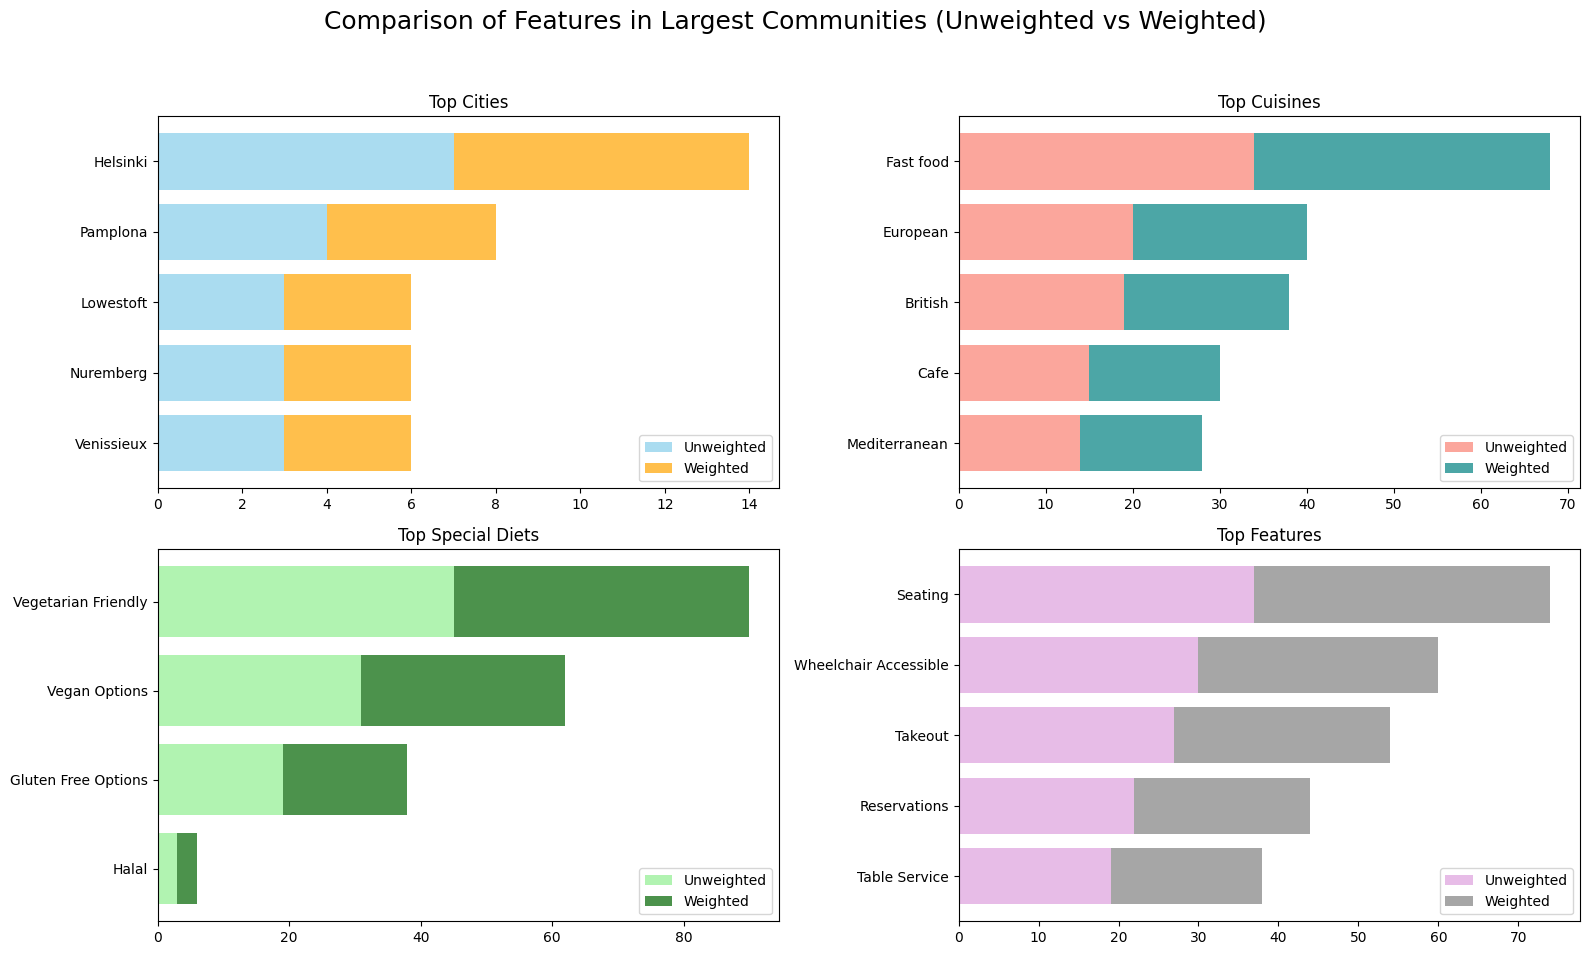

In [160]:


data_unweighted = prepare_plot_data(comm_data_unweighted, "Unweighted")
data_weighted = prepare_plot_data(comm_data_weighted, "Weighted")

# Plot combined bar charts
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"Comparison of Features in Largest Communities (Unweighted vs Weighted)", fontsize=18)

def plot_comparison(ax, feature_key, title, color_u, color_w):
    # Unzip items and align by labels
    items_u = dict(data_unweighted[feature_key])
    items_w = dict(data_weighted[feature_key])
    
    # Union of labels to keep consistent comparison
    all_labels = list(set(items_u.keys()).union(items_w.keys()))
    all_labels.sort(key=lambda x: (-(items_u.get(x, 0) + items_w.get(x, 0)), x))  # sort by total frequency

    values_u = [items_u.get(label, 0) for label in all_labels]
    values_w = [items_w.get(label, 0) for label in all_labels]

    ax.barh(all_labels, values_u, color=color_u, label='Unweighted', alpha=0.7)
    ax.barh(all_labels, values_w, color=color_w, left=values_u, label='Weighted', alpha=0.7)
    ax.set_title(title)
    ax.invert_yaxis()
    ax.legend()

plot_comparison(axs[0, 0], 'cities', 'Top Cities', 'skyblue', 'orange')
plot_comparison(axs[0, 1], 'cuisines', 'Top Cuisines', 'salmon', 'teal')
plot_comparison(axs[1, 0], 'special_diets', 'Top Special Diets', 'lightgreen', 'darkgreen')
plot_comparison(axs[1, 1], 'features', 'Top Features', 'plum', 'grey')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/kaggle/working/task7_Weighted_UnWeighted_Community_Graph_.png')
plt.show()


In [161]:
# Save results
community_df_weighted.to_csv('/kaggle/working/task7_communities.csv', index=False)
# nx.write_gml(G, '/kaggle/working/task7_weighted_graph.gml')
print("Saved community assignments to /kaggle/working/task7_communities.csv and unweighted graph to /kaggle/working/task7_weighted_graph.gml")

Saved community assignments to /kaggle/working/task7_communities.csv and unweighted graph to /kaggle/working/task7_weighted_graph.gml


### 8. Role of Dietary Preferences

- Filter nodes with
  - vegetarian_friendly
  - vegan_options
  - gluten_free tags.
- Analyze their position in the network (e.g., density, centrality, community inclusion).

In [162]:

# Load Task 2 weighted graph, DataFrame, and Task 7 communities
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
community_df_weighted = pd.read_csv('/kaggle/working/task7_communities.csv')
print(f"Loaded weighted graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")
print(f"Loaded Task 7 communities: {len(community_df_weighted)} restaurants")


Loaded weighted graph: 4840 nodes, 11855 edges
Loaded DataFrame: 5000 rows
Loaded Task 7 communities: 5000 restaurants




### Step 1: Filter nodes with vegetarian_friendly, vegan_options, or gluten_free tags
### Parse special_diets column (stringified lists)

In [163]:

print(df.columns.tolist())

 # Define dietary tags

dietary_tags = ['vegetarian_friendly', 'vegan_options', 'gluten_free']
dietary_nodes = []

# Loop through each dietary tag column
for tag in dietary_tags:
    if tag in df.columns:
        matches = df[df[tag] == 'Y']['restaurant_name'].tolist()
        dietary_nodes.extend(matches)

# Remove duplicates
dietary_nodes = list(set(dietary_nodes))
print(f"\n\n====== \n\n Found  {len(dietary_nodes)} restaurants with dietary tags\n\n======")


['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']



 Found  1584 restaurants with dietary tags



In [164]:

# Step 2: Analyze network position
# Create subgraph of dietary nodes

G_dietary = G.subgraph(dietary_nodes)
print(f"Dietary subgraph: {G_dietary.number_of_nodes()} nodes, {G_dietary.number_of_edges()} edges")

# Density of dietary subgraph
density = nx.density(G_dietary)

full_graph_density = nx.density(G)
print(f"\nDensity Analysis:")
print(f"Dietary subgraph density: {density:.6f}")
print(f"Full graph density: {full_graph_density:.6f}")
print("(Higher density means more connections among dietary restaurants)")

# Centrality in the full graph
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=min(1000, G.number_of_nodes()), weight='weight')

# Compute centrality for dietary nodes
dietary_centrality = pd.DataFrame({
    'restaurant_name': dietary_nodes,
    'degree_centrality': [degree_centrality[node] for node in dietary_nodes],
    'betweenness_centrality': [betweenness_centrality[node] for node in dietary_nodes]
})


# Average centrality for dietary vs. all nodes
avg_degree_dietary = dietary_centrality['degree_centrality'].mean()
avg_degree_all = sum(degree_centrality.values()) / len(degree_centrality)
avg_betweenness_dietary = dietary_centrality['betweenness_centrality'].mean()
avg_betweenness_all = sum(betweenness_centrality.values()) / len(betweenness_centrality)

print(f"\nCentrality Analysis:")
print(f"Average degree centrality (dietary): {avg_degree_dietary:.6f}")
print(f"Average degree centrality (all): {avg_degree_all:.6f}")
print(f"Average betweenness centrality (dietary): {avg_betweenness_dietary:.6f}")
print(f"Average betweenness centrality (all): {avg_betweenness_all:.6f}")
print("(Higher centrality means dietary restaurants are more connected or influential)")


Dietary subgraph: 1584 nodes, 1422 edges

Density Analysis:
Dietary subgraph density: 0.001134
Full graph density: 0.001012
(Higher density means more connections among dietary restaurants)

Centrality Analysis:
Average degree centrality (dietary): 0.001040
Average degree centrality (all): 0.001012
Average betweenness centrality (dietary): 0.000009
Average betweenness centrality (all): 0.000009
(Higher centrality means dietary restaurants are more connected or influential)


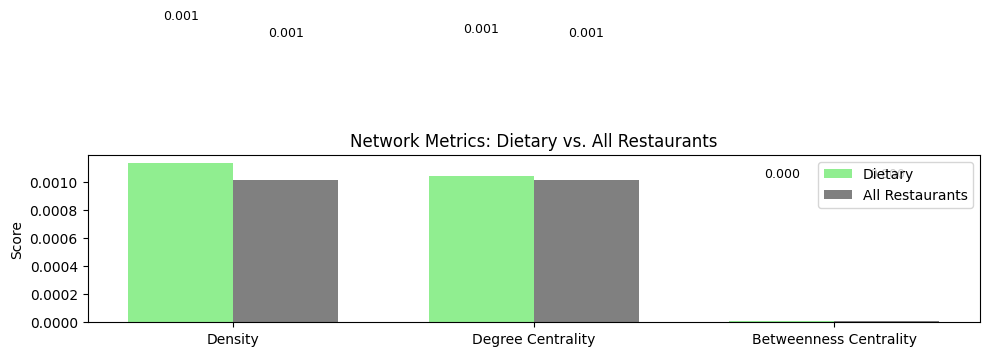

In [166]:


# Data from your analysis
labels = ['Density', 'Degree Centrality', 'Betweenness Centrality']
dietary_vals = [
    density,
    avg_degree_dietary,
    avg_betweenness_dietary
]
all_vals = [
    full_graph_density,
    avg_degree_all,
    avg_betweenness_all
]

x = range(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], dietary_vals, width, label='Dietary', color='lightgreen')
ax.bar([i + width/2 for i in x], all_vals, width, label='All Restaurants', color='gray')

# Labels and aesthetics
ax.set_ylabel('Score')
ax.set_title('Network Metrics: Dietary vs. All Restaurants')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for i in x:
    ax.text(i - width/2, dietary_vals[i] + 0.001, f"{dietary_vals[i]:.3f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, all_vals[i] + 0.001, f"{all_vals[i]:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/task8_NetworkMetric_plot.png')
plt.show()


In [177]:

# Top 5 dietary nodes by centrality
print(f"\nTop 5 Dietary Restaurants by Degree Centrality:")
print(dietary_centrality.sort_values('degree_centrality', ascending=False)[['restaurant_name', 'degree_centrality']].head())
print(f"\nTop 5 Dietary Restaurants by Betweenness Centrality:")
print(dietary_centrality.sort_values('betweenness_centrality', ascending=False)[['restaurant_name', 'betweenness_centrality']].head())

# Community inclusion (using Task 7 weighted communities)
dietary_communities = community_df_weighted[community_df_weighted['restaurant_name'].isin(dietary_nodes)]
community_distribution = dietary_communities['community_weighted'].value_counts()
print(f"\nCommunity Inclusion Analysis:")
print(f"Dietary restaurants in Task 7 communities (top 3):")
print(community_distribution.head())
print(f"Total communities with dietary restaurants: {len(community_distribution)}")

# Analyze dietary tags per community


# from collections import Counter

# Define dietary tags
# dietary_tags = ['vegetarian_friendly', 'vegan_options', 'gluten_free']

print("\n=== Dietary Tags in Top 3 Communities ===")
top_communities = community_df_weighted['community_weighted'].value_counts().head(3).index

for comm in top_communities:
    # Filter the community
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    
    # Find all restaurant names in this community
    comm_nodes = comm_df['restaurant_name'].tolist()
    
    # Initialize tag counter
    tag_counter = Counter()
    
    # For each tag, check which restaurants in this community have 'Y'
    for tag in dietary_tags:
        # Get restaurant names where the tag is 'Y'
        y_nodes = df[df[tag] == 'Y']['restaurant_name']
        
        # Count how many of those nodes are in the current community
        count = sum(name in comm_nodes for name in y_nodes)
        tag_counter[tag] = count

    print(f"\nCommunity {comm} ({len(comm_df)} total restaurants):")
    for tag, count in tag_counter.items():
        print(f"  {tag}: {count} restaurants with '{tag}' = Y")

# print(dietary_centrality.isna().mean()*100)




Top 5 Dietary Restaurants by Degree Centrality:
           restaurant_name  degree_centrality
965     Restaurant Sannine           0.015706
1281  Accents Table Bourse           0.015706
298       Chez Ann Paradis           0.015499
1315              Angelina           0.015499
716          Le Barramundi           0.015499

Top 5 Dietary Restaurants by Betweenness Centrality:
       restaurant_name  betweenness_centrality
837          Pizza Hut                0.002675
118       China Palace                0.002604
989  L'eau a la bouche                0.001840
298   Chez Ann Paradis                0.000632
636    Turkish Kitchen                0.000607

Community Inclusion Analysis:
Dietary restaurants in Task 7 communities (top 3):
community_weighted
56     49
127    38
143    28
6      21
81     20
Name: count, dtype: int64
Total communities with dietary restaurants: 1102

=== Dietary Tags in Top 3 Communities ===

Community 56 (174 total restaurants):
  vegetarian_friendly: 45 resta

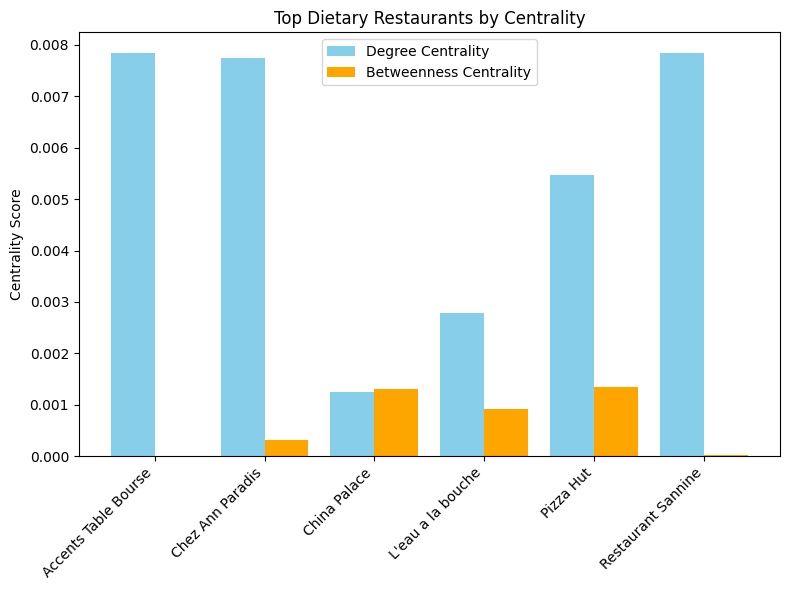

In [195]:
# Get top 5 by degree and betweenness centrality




top_degree = dietary_centrality.sort_values('degree_centrality', ascending=False).head(3)
top_betweenness = dietary_centrality.sort_values('betweenness_centrality', ascending=False).head(3)


# Merge both on restaurant name (in case overlap)
top_combined = pd.merge(top_degree, top_betweenness, on='restaurant_name', how='outer')

top_combined.fillna(0.0, inplace=True)  # Replace NaN with 0 (or any other value you prefer)


# Extract columns dynamically
degree_columns = [col for col in top_combined.columns if 'degree_centrality' in col]
betweenness_columns = [col for col in top_combined.columns if 'betweenness_centrality' in col]

# Merge degree centrality and betweenness centrality, filling NaN values with 0
top_combined['degree_centrality'] = top_combined[degree_columns].fillna(0).mean(axis=1)  # Averaging both degree columns
top_combined['betweenness_centrality'] = top_combined[betweenness_columns].fillna(0).mean(axis=1)  # Averaging both betweenness columns

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(top_combined))

# Plot bars for degree and betweenness centrality
ax.bar(x, top_combined['degree_centrality'], width=0.4, label='Degree Centrality', color='skyblue')
ax.bar([i + 0.4 for i in x], top_combined['betweenness_centrality'], width=0.4, label='Betweenness Centrality', color='orange')

# Set the x-ticks and labels
ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(top_combined['restaurant_name'], rotation=45, ha='right')

# Title, labels, and legend
ax.set_title('Top Dietary Restaurants by Centrality')
ax.set_ylabel('Centrality Score')
ax.legend()

# Layout adjustment and display
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Dietary_graph.png")
plt.show()






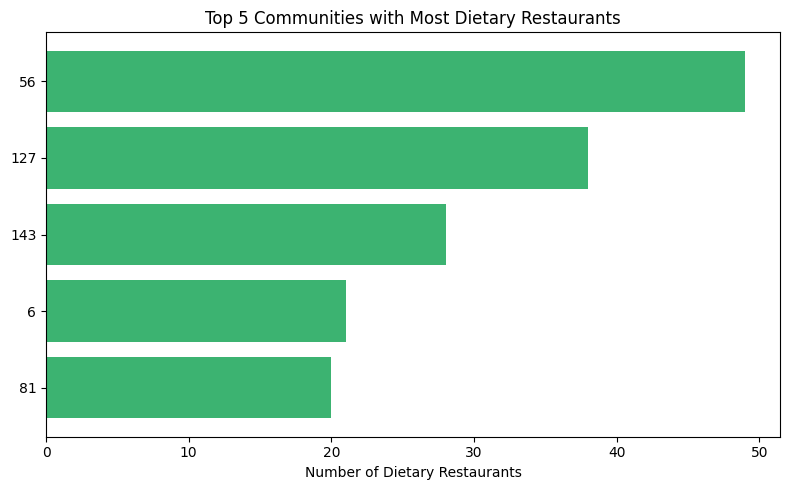

In [197]:
# Plot top 5 community distributions
top_community_dist = community_distribution.head(5)
top_community_dist = top_community_dist.sort_values(ascending=True)  # horizontal bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_community_dist.index.astype(str), top_community_dist.values, color='mediumseagreen')
ax.set_xlabel('Number of Dietary Restaurants')
ax.set_title('Top 5 Communities with Most Dietary Restaurants')
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Top_Community_Dietary_Restaurants.png")
plt.show()


In [198]:
# Collect dietary tag counts for each community
tag_data = []

for comm in top_communities:
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    comm_nodes = comm_df['restaurant_name'].tolist()
    tag_counter = Counter()

    for tag in dietary_tags:
        y_nodes = df[df[tag] == 'Y']['restaurant_name']
        count = sum(name in comm_nodes for name in y_nodes)
        tag_counter[tag] = count

    tag_data.append({
        'community': comm,
        **tag_counter
    })

# Create DataFrame
tag_df = pd.DataFrame(tag_data)
tag_df.set_index('community', inplace=True)


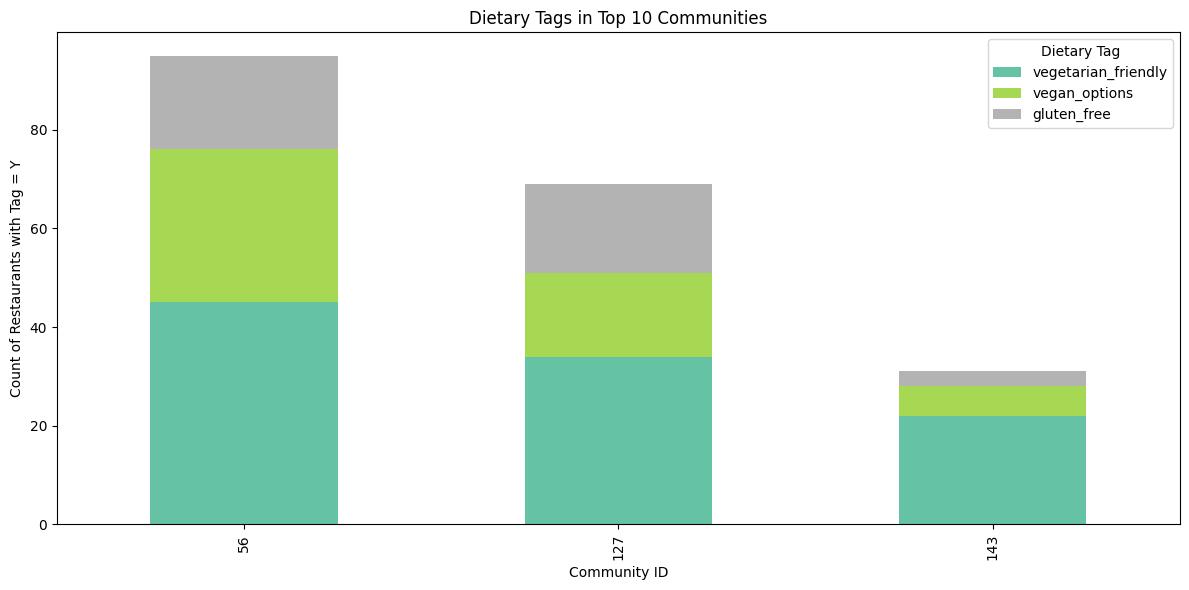

In [200]:
# Plot stacked bar chart
tag_df_sorted = tag_df.sort_index()  # optional sorting

ax = tag_df_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
ax.set_title('Dietary Tags in Top 10 Communities')
ax.set_xlabel('Community ID')
ax.set_ylabel('Count of Restaurants with Tag = Y')
ax.legend(title='Dietary Tag')
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Dietary_tags.png")
plt.show()


In [202]:
dietary_centrality.to_csv('/kaggle/working/task8_dietary_analysis.csv', index=False)
print("Saved analysis to /kaggle/working/task8_dietary_analysis.csv")

Saved analysis to /kaggle/working/task8_dietary_analysis.csv


In [203]:
!zip -r /kaggle/working/my_outputs.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/task2_graph.gml (deflated 81%)
  adding: kaggle/working/task2_df.parquet (deflated 14%)
  adding: kaggle/working/task6_largest_community_top_features.png (deflated 25%)
  adding: kaggle/working/task2_graph.png (deflated 5%)
  adding: kaggle/working/task8_NetworkMetric_plot.png (deflated 25%)
  adding: kaggle/working/task5_heatmap.png (deflated 16%)
  adding: kaggle/working/task8_Dietary_tags.png (deflated 23%)
  adding: kaggle/working/task4_bar_plots.png (deflated 21%)
  adding: kaggle/working/task7_communities.csv (deflated 68%)
  adding: kaggle/working/task4_centrality.csv (deflated 72%)
  adding: kaggle/working/task8_dietary_analysis.csv (deflated 66%)
  adding: kaggle/working/task4_graph.gml (deflated 81%)
  adding: kaggle/working/task3_analysis.csv (deflated 67%)
  adding: kaggle/working/reduced_dataset.parquet (deflated 14%)
  adding: kaggle/working/task5_scatter_plots.png (deflated 8%)
  adding: kaggle/working/task8_